# 🍎 YOLO11 Fruit Disease Detection Project

A comprehensive machine learning pipeline for detecting and classifying fruit diseases using YOLO11 (YOLOv11). This project focuses specifically on apple diseases but can be extended to other fruits.

## 🎯 Project Overview

This project implements a complete machine learning pipeline for fruit disease detection using the latest YOLO11 architecture. The pipeline includes:

- Dataset preparation and preprocessing
- Model training with custom configurations
- Comprehensive evaluation and visualization
- Error analysis and performance metrics
- Production-ready inference capabilities

**Key Features:**
- Focus on apple disease classification
- YOLO11 object detection architecture
- Automated data preprocessing
- Comprehensive evaluation metrics
- Visual analysis tools
- Production-ready model export

Connect to Google Drive for data access

In [2]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install machine learning and image processing libraries

In [3]:
!pip install datasets opencv-python scikit-learn pillow

In [4]:
!pip install --upgrade ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

### 🔧 Initial Setup

Imports all required libraries and sets global parameters such as project paths, plot styles, and class mapping variables. This prepares the environment for training and evaluating the YOLO model.


In [5]:
import os
import kagglehub
from ultralytics import YOLO
import shutil
import yaml
from pathlib import Path
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import json
from datetime import datetime
import torch
from tqdm import tqdm

# Configure matplotlib for displaying plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Global variables for the project
PROJECT_DIR = "yolo11_fruits"
DATASET_DIR = os.path.join(PROJECT_DIR, "dataset")
RESULTS_DIR = os.path.join(PROJECT_DIR, "results")
QUICK_TRAINING = False  # Set to False for full training

# Variables to be preserved across steps
class_mapping = {}
class_names = []

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Step 1: Initial Configuration

**Purpose:** Sets up the project directory structure and initializes the working environment.

**What it does:**
- Creates main project directory: `yolo11_fruits/`
- Sets up dataset subdirectories for images and labels
- Creates train/validation splits directories
- Initializes results directory for outputs

**Directory Structure Created:**
```
yolo11_fruits/
├── dataset/
│   ├── images/
│   │   ├── train/
│   │   └── val/
│   └── labels/
│       ├── train/
│       └── val/
└── results/
```

In [6]:
# ============================================================================
# STEP 1: INITIAL SETUP
# ============================================================================
def initial_setup():

    # Create directory structure
    dirs_to_create = [
        DATASET_DIR,
        os.path.join(DATASET_DIR, "images", "train"),
        os.path.join(DATASET_DIR, "images", "val"),
        os.path.join(DATASET_DIR, "labels", "train"),
        os.path.join(DATASET_DIR, "labels", "val"),
        RESULTS_DIR
    ]

    for dir_path in dirs_to_create:
        os.makedirs(dir_path, exist_ok=True)

    print(f"📁 Directories created in: {PROJECT_DIR}")
    print("✅ Initial setup completed\n")
    return True

## Step 2: Dataset Download

**Purpose:** Downloads the fruit disease dataset from Kaggle using the Kaggle API.

**Dataset Details:**
- **Source:** Kaggle dataset "fruits-dataset-for-fruit-disease-classification"
- **Content:** Images of various fruits with different disease conditions
- **Size:** Several GB of image data
- **Format:** JPG/PNG images organized by fruit type and disease

**What it does:**
- Checks if dataset already exists locally
- Downloads dataset using kagglehub
- Returns path to downloaded dataset
- Handles download errors gracefully

In [7]:
# ============================================================================
# STEP 2: DOWNLOAD THE DATASET
# ============================================================================
def download_dataset():
    """Step 2: Download the dataset from Kaggle"""
    print("📥 STEP 2: DOWNLOAD THE DATASET")
    print("=" * 50)

    dataset_id = "ateebnoone/fruits-dataset-for-fruit-disease-classification"
    local_path = os.path.expanduser(f"~/.cache/kagglehub/datasets/{dataset_id}/versions/2/")

    print(local_path)
    if os.path.exists(local_path):
        print(f"✅ Dataset already downloaded at: {local_path}")
        return local_path

    print("🔄 Downloading dataset...")
    try:
        path = kagglehub.dataset_download(dataset_id)
        print(f"✅ Dataset downloaded to: {path}")
        return path
    except Exception as e:
        print(f"❌ Error downloading dataset: {e}")
        return None

## Step 3: Dataset Exploration

**Purpose:** Analyzes the dataset structure and provides insights into the available data.

**What it does:**
- Walks through dataset directory structure
- Counts images in each category
- Identifies available fruit types and diseases
- Provides statistical overview of the dataset

**Analysis Includes:**
- Total number of images
- Number of classes/categories
- Distribution of images per class
- File format verification
- Directory structure visualization

In [8]:
# ============================================================================
# STEP 3: DATASET EXPLORATION
# ============================================================================
def explore_dataset(dataset_path):
    """Step 3: Explore the dataset structure"""
    print("🔍 STEP 3: DATASET EXPLORATION")
    print("=" * 50)

    if not dataset_path or not os.path.exists(dataset_path):
        print("❌ Invalid dataset path")
        return False

    print(f"📁 Dataset structure at: {dataset_path}")
    total_images = 0
    classes_found = []

    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        folder_name = os.path.basename(root)
        print(f"{indent}{folder_name}/")

        # Count images
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        if image_files:
            total_images += len(image_files)
            subindent = ' ' * 2 * (level + 1)

            for file in image_files[:3]:
                print(f"{subindent}{file}")
            if len(image_files) > 3:
                print(f"{subindent}... and {len(image_files) - 3} more files")

        # Identify classes
        if level == 2:  # FRUIT/DISEASE/
            parent_folder = os.path.basename(os.path.dirname(root))
            class_name = f"{parent_folder}_{folder_name}"
            if class_name not in classes_found:
                classes_found.append(class_name)

    print(f"\n📊 Exploration summary:")
    print(f"  • Classes found: {len(classes_found)}")
    print(f"  • Total images: {total_images}")

    return True


## Step 4: Data Preparation for YOLO

**Purpose:** Converts the dataset into YOLO-compatible format focusing on apple diseases.

**Key Features:**
- **Focus:** Apple diseases only (can be modified for other fruits)
- **Format:** YOLO annotation format (class_id x_center y_center width height)
- **Split:** 80% training, 20% validation
- **Stratification:** Ensures balanced class distribution

**What it does:**
- Filters dataset to focus on apple diseases only
- Creates class mapping for detected diseases
- Generates YOLO-format annotations
- Splits data into training and validation sets
- Copies and renames images with systematic naming
- Creates bounding boxes covering entire images
- Validates annotation correctness

**Class Mapping Example:**
```
0: APPLE_HEALTHY
1: APPLE_BLACK_ROT
2: APPLE_CEDAR_RUST
3: APPLE_SCAB
```


In [9]:
# ============================================================================
# STEP 4: PREPARE DATA FOR YOLO
# ============================================================================
def prepare_data_yolo(source_path):
    """Step 4: Convert dataset to YOLO format - APPLES ONLY"""
    global class_mapping, class_names

    print("🔄 STEP 4: PREPARING DATA FOR YOLO - APPLES ONLY")
    print("=" * 50)

    if not source_path or not os.path.exists(source_path):
        print("❌ Invalid dataset path")
        return False, 0, 0

    # CLEAN directories before processing
    print("🧹 Cleaning previous directories...")
    for split in ['train', 'val']:
        images_dir = os.path.join(DATASET_DIR, "images", split)
        labels_dir = os.path.join(DATASET_DIR, "labels", split)

        for file_path in glob.glob(os.path.join(images_dir, "*")):
            os.remove(file_path)
        for file_path in glob.glob(os.path.join(labels_dir, "*")):
            os.remove(file_path)

    classes = []
    image_paths = []

    # ONLY process the APPLE folder
    apple_folder = "APPLE"
    apple_path = os.path.join(source_path, apple_folder)

    if not os.path.exists(apple_path):
        print(f"❌ Folder {apple_folder} not found")
        print("Available folders:")
        for item in os.listdir(source_path):
            item_path = os.path.join(source_path, item)
            if os.path.isdir(item_path):
                print(f"  - {item}")
        return False, 0, 0

    print(f"  📂 Processing only fruit: {apple_folder}")

    # List disease subfolders in APPLE
    disease_folders = []
    for item in os.listdir(apple_path):
        item_path = os.path.join(apple_path, item)
        if os.path.isdir(item_path):
            disease_folders.append(item)

    print(f"  📋 Diseases found: {disease_folders}")

    # Process each apple disease
    for disease_folder in disease_folders:
        disease_path = os.path.join(apple_path, disease_folder)
        class_name = f"{apple_folder}_{disease_folder}"

        if class_name not in classes:
            classes.append(class_name)

        # Search for images in this folder
        image_count = 0
        extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.JPG', '*.JPEG', '*.PNG', '*.BMP']

        for ext in extensions:
            images = glob.glob(os.path.join(disease_path, ext))
            for img_path in images:
                if os.path.isfile(img_path):
                    try:
                        with Image.open(img_path) as img:
                            img.verify()
                        image_paths.append((img_path, class_name))
                        image_count += 1
                    except Exception:
                        print(f"⚠️  Corrupted image ignored: {img_path}")

        print(f"    🖼️  {disease_folder}: {image_count} images")

    if len(image_paths) == 0:
        print("❌ No valid apple images found.")
        return False, 0, 0

    # Create class mapping ONLY for apples
    class_names = sorted(classes)
    class_mapping = {cls: idx for idx, cls in enumerate(class_names)}

    print(f"\n📊 Dataset summary (apples only):")
    print(f"  • Total classes: {len(class_names)}")
    print(f"  • Classes found:")
    for i, cls in enumerate(class_names):
        print(f"    {i}: {cls}")
    print(f"  • Total images: {len(image_paths)}")

    from collections import Counter
    class_distribution = Counter([x[1] for x in image_paths])
    print(f"  • Class distribution:")
    for cls, count in class_distribution.items():
        print(f"    {cls}: {count} images")

    # Split into train/val - ensure at least one image per class in each split
    try:
        train_data, val_data = train_test_split(
            image_paths,
            test_size=0.2,
            random_state=42,
            stratify=[x[1] for x in image_paths]
        )
    except ValueError as e:
        print(f"⚠️  Stratify error: {e}")
        print("  Using simple split without stratification")
        train_data, val_data = train_test_split(
            image_paths,
            test_size=0.2,
            random_state=42
        )

    # Process splits
    print(f"\n🔄 Processing data...")
    train_count = process_data_split(train_data, "train")
    val_count = process_data_split(val_data, "val")

    print(f"  ✅ Train: {train_count} images processed")
    print(f"  ✅ Val: {val_count} images processed")

    # Check that files were created correctly
    train_images = len(glob.glob(os.path.join(DATASET_DIR, "images", "train", "*.jpg")))
    val_images = len(glob.glob(os.path.join(DATASET_DIR, "images", "val", "*.jpg")))
    train_labels = len(glob.glob(os.path.join(DATASET_DIR, "labels", "train", "*.txt")))
    val_labels = len(glob.glob(os.path.join(DATASET_DIR, "labels", "val", "*.txt")))

    print(f"  📁 Files created:")
    print(f"    Train: {train_images} images, {train_labels} labels")
    print(f"    Val: {val_images} images, {val_labels} labels")

    # FINAL CHECK: Ensure all labels use valid classes
    print(f"\n🔍 Checking labels...")
    max_class_found = check_valid_labels()
    print(f"  • Maximum class found in labels: {max_class_found}")
    print(f"  • Valid classes: 0–{len(class_names) - 1}")

    if max_class_found >= len(class_names):
        print(f"❌ ERROR: Labels contain invalid class IDs!")
        return False, 0, 0

    return True, train_count, val_count


def check_valid_labels():
    """Helper function to check that all labels use valid class IDs"""
    max_class = -1

    for split in ['train', 'val']:
        labels_dir = os.path.join(DATASET_DIR, "labels", split)
        label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

        for label_file in label_files:
            try:
                with open(label_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if parts:
                            class_id = int(parts[0])
                            max_class = max(max_class, class_id)
            except Exception as e:
                print(f"⚠️  Error reading {label_file}: {e}")

    return max_class


def process_data_split(data, split_name):
    """Helper function to process a data split - IMPROVED"""
    processed = 0
    for img_path, class_name in tqdm(data):
        try:
            if class_name not in class_mapping:
                print(f"⚠️  Class not found in mapping: {class_name}")
                continue

            base_name = os.path.splitext(os.path.basename(img_path))[0]
            img_name = f"{class_name}_{base_name}.jpg"
            dest_img_path = os.path.join(DATASET_DIR, "images", split_name, img_name)

            # Copy image
            shutil.copy2(img_path, dest_img_path)

            # Create YOLO annotation
            img = cv2.imread(img_path)
            if img is not None:
                class_id = class_mapping[class_name]

                if class_id >= len(class_names):
                    print(f"❌ ERROR: Invalid class_id {class_id} for {class_name}")
                    continue

                label_name = f"{class_name}_{base_name}.txt"
                label_path = os.path.join(DATASET_DIR, "labels", split_name, label_name)

                with open(label_path, 'w') as f:
                    f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

                processed += 1
        except Exception as e:
            print(f"⚠️  Error processing {img_path}: {e}")

    return processed


## Step 5: Configuration File Creation

**Purpose:** Creates a YAML configuration file required for YOLO training.

**Configuration Contents:**
- Dataset paths (absolute paths)
- Number of classes
- Class names mapping
- Training and validation data locations

**Generated YAML Structure:**
```yaml
path: /absolute/path/to/dataset
train: images/train
val: images/val
nc: 4  # number of classes
names:
  - APPLE_HEALTHY
  - APPLE_BLACK_ROT
  - APPLE_CEDAR_RUST
  - APPLE_SCAB
```

In [10]:
# ============================================================================
# STEP 5: CREATE CONFIGURATION FILE
# ============================================================================
def create_config_file():
    """Step 5: Create YAML configuration file"""
    print("📝 STEP 5: CREATE YAML CONFIGURATION FILE")
    print("=" * 50)

    if not class_names:
        print("❌ No classes defined. Please run Step 4 first.")
        return None

    config_data = {
        'path': os.path.abspath(DATASET_DIR),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(class_names),
        'names': class_names
    }

    config_path = os.path.join(PROJECT_DIR, 'fruit_config.yaml')
    with open(config_path, 'w') as f:
        yaml.dump(config_data, f, default_flow_style=False)

    print(f"✅ Configuration saved at: {config_path}")
    print(f"  • Number of classes: {len(class_names)}")
    print(f"  • Classes: {', '.join(class_names[:5])}{'...' if len(class_names) > 5 else ''}")

    return config_path

## Step 6: Class Distribution Analysis

**Purpose:** Creates visualizations showing the distribution of classes in training and validation sets.

**What it does:**
- Counts images per class in both splits
- Creates bar chart visualization
- Identifies potential class imbalance issues
- Saves distribution plot as PNG

**Visualization Features:**
- Side-by-side bars for train/validation
- Color-coded bars
- Rotated labels for readability
- Grid for better visualization
- Statistical summary

In [11]:
# ============================================================================
# STEP 6: CLASS DISTRIBUTION ANALYSIS
# ============================================================================
def analyze_class_distribution():
    """Step 6: Create class distribution chart"""
    print("📊 STEP 6: CLASS DISTRIBUTION ANALYSIS")
    print("=" * 50)

    if not class_names:
        print("❌ No classes defined. Please run Step 4 first.")
        return False

    train_dir = os.path.join(DATASET_DIR, "images", "train")
    val_dir = os.path.join(DATASET_DIR, "images", "val")

    # Valid image extensions
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    # Count images per class
    class_counts_train = {}
    class_counts_val = {}

    for class_name in class_names:
        # Count train images
        train_files = glob.glob(os.path.join(train_dir, f"{class_name}_*"))
        train_count = sum(1 for f in train_files if f.lower().endswith(valid_exts))

        # Count validation images
        val_files = glob.glob(os.path.join(val_dir, f"{class_name}_*"))
        val_count = sum(1 for f in val_files if f.lower().endswith(valid_exts))

        class_counts_train[class_name] = train_count
        class_counts_val[class_name] = val_count

    # Create plot
    fig, ax = plt.subplots(figsize=(15, 8))

    x = np.arange(len(class_names))
    width = 0.35

    train_counts = [class_counts_train[cls] for cls in class_names]
    val_counts = [class_counts_val[cls] for cls in class_names]

    ax.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
    ax.bar(x + width/2, val_counts, width, label='Validation', alpha=0.8)

    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title('Class Distribution in Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot
    dist_plot_path = os.path.join(RESULTS_DIR, 'class_distribution.png')
    plt.savefig(dist_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"📊 Class distribution plot saved at: {dist_plot_path}")
    return True


## Step 7: Model Training

**Purpose:** Trains the YOLO11 model using the prepared dataset.

**Training Configuration:**
- **Model:** YOLO11n (nano version for faster training)
- **Quick Training:** 10 epochs (for testing)
- **Full Training:** 100 epochs (for production)
- **Auto-GPU:** Automatically uses CUDA if available
- **Optimization:** SGD optimizer with learning rate 0.01

**Training Parameters:**
```python
# Quick Training Mode
epochs=10, imgsz=416, batch=8

# Full Training Mode  
epochs=100, imgsz=640, batch=16
```

**What it does:**
- Loads pre-trained YOLO11 weights
- Configures training parameters based on hardware
- Trains model with progress monitoring
- Saves best model weights
- Generates training plots and metrics
- Creates comprehensive training logs

In [12]:
# ============================================================================
# STEP 7: MODEL TRAINING
# ============================================================================
def train_model(config_path):
    """Step 7: Train the YOLO11 model"""
    print("🚀 STEP 7: MODEL TRAINING")
    print("=" * 50)

    if not config_path or not os.path.exists(config_path):
        print("❌ Configuration file not found")
        return None, None

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"  • Device: {device}")

    if device == 'cuda':
        print(f"  • GPU: {torch.cuda.get_device_name(0)}")
        print(f"  • GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

    # Load model
    model = YOLO('yolo11n.pt')

    # Training parameters
    if QUICK_TRAINING:
        epochs, imgsz, batch = 1, 416, 8 if device == 'cuda' else 4
        print("  • Mode: Quick training (1 epoch)")
    else:
        epochs, imgsz, batch = 100, 640, 16 if device == 'cuda' else 8
        print("  • Mode: Full training (100 epochs)")

    training_params = {
        'data': config_path,
        'epochs': epochs,
        'imgsz': imgsz,
        'batch': batch,
        'workers': 4 if device == 'cuda' else 2,
        'patience': 20,
        'save_period': 10,
        'cache': True,
        'device': device,
        'project': PROJECT_DIR,
        'name': 'fruit_detection',
        'exist_ok': True,
        'pretrained': True,
        'optimizer': 'SGD',
        'lr0': 0.01,
        'plots': True,
        'save_json': True,
    }

    print(f"  • Batch size: {batch}")
    print(f"  • Image size: {imgsz}px")
    print(f"  • Epochs: {epochs}")

    # Train
    print("🔄 Starting training...")
    results = model.train(**training_params)

    model_path = os.path.join(PROJECT_DIR, 'fruit_detection', 'weights', 'best.pt')
    print(f"✅ Training complete! Model saved at: {model_path}")

    return model, model_path


## Step 8: Training Metrics Visualization

**Purpose:** Creates comprehensive visualizations of training metrics and performance.

**Metrics Visualized:**
1. **Box Loss:** Training and validation bounding box loss
2. **Classification Loss:** Training and validation classification loss
3. **Precision:** Model precision over epochs
4. **Recall:** Model recall over epochs
5. **mAP@0.5:** Mean Average Precision at IoU threshold 0.5
6. **F1 Score:** Calculated F1 score over epochs

**Visualization Features:**
- 2x3 subplot layout
- Color-coded train/validation curves
- Grid for better readability
- Legends and proper labeling
- High-resolution output (300 DPI)

In [13]:
# ============================================================================
# STEP 8: VISUALIZE TRAINING METRICS
# ============================================================================
def visualize_training_metrics():
    """Step 8: Visualize training metrics"""
    print("📈 STEP 8: VISUALIZE TRAINING METRICS")
    print("=" * 50)

    results_path = os.path.join(PROJECT_DIR, 'fruit_detection', 'results.csv')

    if not os.path.exists(results_path):
        print("⚠️  Training metrics file not found")
        return False

    # Read metrics
    df = pd.read_csv(results_path)
    df.columns = df.columns.str.strip()

    # Clean data: remove NaN values and sort by epoch
    df = df.dropna(subset=['epoch'])
    df = df.sort_values('epoch').reset_index(drop=True)

    # Ensure epoch column is numeric
    df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce')
    df = df.dropna(subset=['epoch'])

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('YOLO11 Training Metrics - Garbage Classification', fontsize=16)

    # Helper function to plot metrics safely
    def safe_plot(ax, x_data, y_data, label, color, title):
        # Remove NaN values from both x and y
        mask = ~(pd.isna(x_data) | pd.isna(y_data))
        if mask.sum() > 0:  # Only plot if we have valid data
            x_clean = x_data[mask]
            y_clean = y_data[mask]
            ax.plot(x_clean, y_clean, label=label, color=color, marker='o', markersize=3)
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Box Loss
    if 'train/box_loss' in df.columns and 'val/box_loss' in df.columns:
        safe_plot(axes[0, 0], df['epoch'], df['train/box_loss'], 'Train Box Loss', 'blue', 'Box Loss')
        safe_plot(axes[0, 0], df['epoch'], df['val/box_loss'], 'Val Box Loss', 'red', 'Box Loss')
        axes[0, 0].set_ylabel('Loss')
    elif 'train/box_loss' in df.columns:
        safe_plot(axes[0, 0], df['epoch'], df['train/box_loss'], 'Train Box Loss', 'blue', 'Box Loss')
        axes[0, 0].set_ylabel('Loss')

    # Classification Loss
    if 'train/cls_loss' in df.columns and 'val/cls_loss' in df.columns:
        safe_plot(axes[0, 1], df['epoch'], df['train/cls_loss'], 'Train Cls Loss', 'blue', 'Classification Loss')
        safe_plot(axes[0, 1], df['epoch'], df['val/cls_loss'], 'Val Cls Loss', 'red', 'Classification Loss')
        axes[0, 1].set_ylabel('Loss')
    elif 'train/cls_loss' in df.columns:
        safe_plot(axes[0, 1], df['epoch'], df['train/cls_loss'], 'Train Cls Loss', 'blue', 'Classification Loss')
        axes[0, 1].set_ylabel('Loss')

    # Precision
    if 'metrics/precision(B)' in df.columns:
        safe_plot(axes[0, 2], df['epoch'], df['metrics/precision(B)'], 'Precision', 'green', 'Precision')
        axes[0, 2].set_ylabel('Precision')

    # Recall
    if 'metrics/recall(B)' in df.columns:
        safe_plot(axes[1, 0], df['epoch'], df['metrics/recall(B)'], 'Recall', 'orange', 'Recall')
        axes[1, 0].set_ylabel('Recall')

    # mAP@50
    if 'metrics/mAP50(B)' in df.columns:
        safe_plot(axes[1, 1], df['epoch'], df['metrics/mAP50(B)'], 'mAP50', 'purple', 'mAP@0.5')
        axes[1, 1].set_ylabel('mAP')

    # F1 Score (calculated)
    if 'metrics/precision(B)' in df.columns and 'metrics/recall(B)' in df.columns:
        precision = pd.to_numeric(df['metrics/precision(B)'], errors='coerce')
        recall = pd.to_numeric(df['metrics/recall(B)'], errors='coerce')

        # Calculate F1 only for valid precision and recall values
        valid_mask = ~(pd.isna(precision) | pd.isna(recall)) & (precision > 0) & (recall > 0)
        if valid_mask.sum() > 0:
            f1 = pd.Series(index=df.index, dtype=float)
            f1[valid_mask] = 2 * (precision[valid_mask] * recall[valid_mask]) / (precision[valid_mask] + recall[valid_mask])

            safe_plot(axes[1, 2], df['epoch'], f1, 'F1 Score', 'red', 'F1 Score')
            axes[1, 2].set_ylabel('F1 Score')

    # Remove empty subplots
    for i in range(2):
        for j in range(3):
            if not axes[i, j].lines:  # If no lines were plotted
                axes[i, j].set_visible(False)

    plt.tight_layout()

    # Save plot
    metrics_plot_path = os.path.join(RESULTS_DIR, 'training_metrics.png')
    plt.savefig(metrics_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"📊 Metric plots saved at: {metrics_plot_path}")

    # Show final metrics
    if len(df) > 0:
        final_metrics = df.iloc[-1]
        print(f"\n📈 Final metrics (Epoch {int(final_metrics['epoch'])}):")

        metrics_to_show = [
            ('Precision', 'metrics/precision(B)'),
            ('Recall', 'metrics/recall(B)'),
            ('mAP50', 'metrics/mAP50(B)'),
            ('mAP50-95', 'metrics/mAP50-95(B)')
        ]

        for name, col in metrics_to_show:
            if col in final_metrics and pd.notna(final_metrics[col]):
                print(f"  • {name}: {final_metrics[col]:.4f}")

    return True

## Step 9: Model Evaluation

**Purpose:** Performs comprehensive evaluation of the trained model on validation data.

**Evaluation Metrics:**
- **mAP@0.5:** Mean Average Precision at IoU 0.5
- **mAP@0.5:0.95:** Mean Average Precision across IoU thresholds
- **Precision:** Overall model precision
- **Recall:** Overall model recall

**What it does:**
- Loads trained model
- Runs validation on test set
- Calculates comprehensive metrics
- Generates evaluation plots
- Saves detailed results


In [14]:
# ============================================================================
# STEP 9: MODEL EVALUATION
# ============================================================================
def evaluate_model(model_path, config_path):
    """Step 9: Evaluate the model and show detailed metrics"""
    print("🔍 STEP 9: MODEL EVALUATION")
    print("=" * 50)

    if not model_path or not os.path.exists(model_path):
        print("❌ Model not found")
        return None

    if not config_path or not os.path.exists(config_path):
        print("❌ Configuration not found")
        return None

    model = YOLO(model_path)
    results = model.val(data=config_path, plots=True, save_json=True)

    print(f"📊 Evaluation results:")
    print(f"  • mAP50: {results.box.map50:.4f}")
    print(f"  • mAP50-95: {results.box.map:.4f}")
    print(f"  • Precision: {results.box.mp:.4f}")
    print(f"  • Recall: {results.box.mr:.4f}")

    return results

## Step 10: Prediction Visualization

**Purpose:** Creates visual demonstrations of model predictions on sample images.

**What it does:**
- Selects sample images from validation set
- Runs inference on selected images
- Draws bounding boxes and labels
- Shows confidence scores
- Compares predictions with ground truth

**Visualization Features:**
- 2x3 grid of predicted images
- Bounding boxes with confidence scores
- Class labels and predictions
- True class labels for comparison
- High-quality output for presentation

In [15]:
# ============================================================================
# STEP 10: PREDICTION VISUALIZATION
# ============================================================================
def visualize_predictions(model_path, sample_images=6):
    """Step 10: Create prediction visualizations"""
    print("🎨 STEP 10: PREDICTION VISUALIZATION")
    print("=" * 50)

    if not model_path or not os.path.exists(model_path):
        print("❌ Model not found")
        return False

    model = YOLO(model_path)

    # Get validation images
    val_images_dir = os.path.join(DATASET_DIR, "images", "val")
    image_files = glob.glob(os.path.join(val_images_dir, "*.jpg"))[:sample_images]

    if not image_files:
        print("⚠️  No validation images found")
        return False

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('YOLO11 Model Predictions - Fruit Disease Detection', fontsize=16)

    axes = axes.flatten()

    for i, img_path in enumerate(image_files[:6]):
        if i >= len(axes):
            break

        # Make prediction
        results = model.predict(img_path, conf=0.5, verbose=False)

        # Load image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get predictions
        if len(results) > 0 and len(results[0].boxes) > 0:
            boxes = results[0].boxes
            for box in boxes:
                # Get box info
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = class_names[class_id]

                # Draw on image
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Add label text
                label = f"{class_name}: {confidence:.2f}"
                (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
                cv2.rectangle(img_rgb, (x1, y1 - text_height - 10), (x1 + text_width, y1), (0, 255, 0), -1)
                cv2.putText(img_rgb, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Show image
        axes[i].imshow(img_rgb)
        axes[i].axis('off')

        # Extract true class name from filename
        filename = os.path.basename(img_path)
        true_class = filename.split('_')[0] + '_' + filename.split('_')[1]
        axes[i].set_title(f'True: {true_class}', fontsize=10)

    plt.tight_layout()

    # Save visualization
    pred_plot_path = os.path.join(RESULTS_DIR, 'predictions_visualization.png')
    plt.savefig(pred_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"🎨 Visualizations saved to: {pred_plot_path}")
    return True


## Step 11: Inference Demonstration

**Purpose:** Demonstrates real-time inference capabilities with detailed performance analysis.

**What it does:**
- Processes multiple test images
- Performs inference with confidence thresholding
- Compares predictions with ground truth
- Calculates accuracy metrics
- Generates detailed results summary

**Performance Metrics:**
- Overall accuracy percentage
- Average confidence scores
- Successful detection rate
- Detailed per-image results

In [16]:
# ============================================================================
# STEP 11: INFERENCE DEMONSTRATION
# ============================================================================
def inference_demo(model_path):
    """Step 11: Interactive inference demonstration"""
    print("🎯 STEP 11: INFERENCE DEMONSTRATION")
    print("=" * 50)

    if not model_path or not os.path.exists(model_path):
        print("❌ Model not found")
        return None

    model = YOLO(model_path)

    # Get some validation images
    val_dir = os.path.join(DATASET_DIR, "images", "val")
    test_images = glob.glob(os.path.join(val_dir, "*.jpg"))[:10]

    if not test_images:
        print("⚠️  No images found for the demo")
        return None

    print(f"🖼️  Processing {len(test_images)} sample images...")

    results_summary = []

    for i, img_path in enumerate(test_images):
        filename = os.path.basename(img_path)
        true_class = filename.split('_')[0] + '_' + filename.split('_')[1] + "_" + filename.split('_')[2]

        # Perform prediction
        results = model.predict(img_path, conf=0.5, verbose=False)

        if len(results) > 0 and len(results[0].boxes) > 0:
            # Get best prediction
            best_box = results[0].boxes[0]
            predicted_class_id = int(best_box.cls[0])
            confidence = float(best_box.conf[0])
            predicted_class = class_names[predicted_class_id]

            # Check if correct
            is_correct = predicted_class == true_class
            status = "✅ CORRECT" if is_correct else "❌ INCORRECT"

            print(f"\n🖼️  Image {i+1}: {filename}")
            print(f"   📋 True class: {true_class}")
            print(f"   🎯 Prediction: {predicted_class} (confidence: {confidence:.3f})")
            print(f"   📊 Status: {status}")

            results_summary.append({
                'image': filename,
                'true_class': true_class,
                'prediction': predicted_class,
                'confidence': confidence,
                'correct': is_correct
            })
        else:
            print(f"\n🖼️  Image {i+1}: {filename}")
            print(f"   📋 True class: {true_class}")
            print(f"   ⚠️  No object detected")

            results_summary.append({
                'image': filename,
                'true_class': true_class,
                'prediction': 'Not detected',
                'confidence': 0.0,
                'correct': False
            })

    # Create DataFrame of results
    df_results = pd.DataFrame(results_summary)

    # Calculate statistics
    accuracy = df_results['correct'].mean()
    avg_confidence = df_results[df_results['confidence'] > 0]['confidence'].mean()

    print(f"\n📊 DEMONSTRATION SUMMARY:")
    print(f"   🎯 Accuracy: {accuracy:.1%} ({df_results['correct'].sum()}/{len(df_results)})")
    print(f"   📈 Average confidence: {avg_confidence:.3f}")
    print(f"   🔍 Successful detections: {len(df_results[df_results['confidence'] > 0])}/{len(df_results)}")

    # Save results
    results_csv_path = os.path.join(RESULTS_DIR, 'inference_demo_results.csv')
    df_results.to_csv(results_csv_path, index=False)
    print(f"   💾 Results saved at: {results_csv_path}")

    return df_results


## Step 12: Confusion Matrix

**Purpose:** Generates detailed confusion matrix and classification report.

**What it does:**
- Processes all validation images
- Creates confusion matrix
- Calculates per-class metrics
- Generates classification report
- Visualizes confusion matrix as heatmap

**Metrics Calculated:**
- Per-class precision, recall, F1-score
- Support (number of samples per class)
- Macro-averaged metrics
- Confusion matrix visualization

In [17]:
# ============================================================================
# STEP 12: CONFUSION MATRIX
# ============================================================================
def build_confusion_matrix(model_path):
    """Step 12: Generate detailed confusion matrix"""
    print("📊 STEP 12: CONFUSION MATRIX")
    print("=" * 50)

    if not model_path or not os.path.exists(model_path):
        print("❌ Model not found")
        return False

    model = YOLO(model_path)

    # Get all validation images
    val_dir = os.path.join(DATASET_DIR, "images", "val")
    test_images = glob.glob(os.path.join(val_dir, "*.jpg"))

    if not test_images:
        print("⚠️  No validation images found")
        return False

    print(f"🔄 Processing {len(test_images)} images...")

    y_true = []
    y_pred = []

    for img_path in test_images:
        # Get true class from filename
        filename = os.path.basename(img_path)
        true_class = filename.split('_')[0] + '_' + filename.split('_')[1] + "_" + filename.split('_')[2]
        true_class_id = class_mapping.get(true_class, -1)

        if true_class_id == -1:
            continue

        # Perform prediction
        results = model.predict(img_path, conf=0.3, verbose=False)

        if len(results) > 0 and len(results[0].boxes) > 0:
            # Get best prediction
            best_box = results[0].boxes[0]
            predicted_class_id = int(best_box.cls[0])
        else:
            # If no detection, assign "unknown" class (-1)
            predicted_class_id = -1

        y_true.append(true_class_id)
        y_pred.append(predicted_class_id)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Predictions'})
    plt.title('Confusion Matrix - Fruit Disease Detection')
    plt.xlabel('Prediction')
    plt.ylabel('True Class')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save plot
    cm_plot_path = os.path.join(RESULTS_DIR, 'confusion_matrix.png')
    plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate metrics per class
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
    )

    # Classification report
    print(f"\n📈 CLASSIFICATION REPORT:")
    print("-" * 80)
    print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 80)

    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {precision[i]:<10.3f} {recall[i]:<10.3f} {f1[i]:<10.3f} {support[i]:<10}")

    # Global metrics
    macro_avg_precision = np.mean(precision)
    macro_avg_recall = np.mean(recall)
    macro_avg_f1 = np.mean(f1)

    print("-" * 80)
    print(f"{'Macro Avg':<20} {macro_avg_precision:<10.3f} {macro_avg_recall:<10.3f} {macro_avg_f1:<10.3f} {sum(support):<10}")

    # Save report
    report_dict = classification_report(y_true, y_pred, target_names=class_names,
                                        labels=list(range(len(class_names))),
                                        zero_division=0, output_dict=True)

    report_path = os.path.join(RESULTS_DIR, 'classification_report.json')
    with open(report_path, 'w') as f:
        json.dump(report_dict, f, indent=2)

    print(f"\n💾 Confusion matrix saved at: {cm_plot_path}")
    print(f"💾 Classification report saved at: {report_path}")

    return True


## Step 13: Error Analysis

**Purpose:** Performs detailed analysis of model errors and failure cases.

**What it does:**
- Identifies all incorrect predictions
- Categorizes error types
- Analyzes confidence scores in errors
- Visualizes common failure cases
- Provides insights for model improvement

**Error Analysis Includes:**
- Most common error patterns
- Confidence analysis of wrong predictions
- Visual examples of failure cases
- Recommendations for improvement

In [19]:
# ============================================================================
# STEP 13: ERROR ANALYSIS
# ============================================================================
def error_analysis(model_path):
    """Step 13: Detailed error analysis of the model"""
    print("🔍 STEP 13: ERROR ANALYSIS")
    print("=" * 50)

    if not model_path or not os.path.exists(model_path):
        print("❌ Model not found")
        return False

    model = YOLO(model_path)

    # Get validation images
    val_dir = os.path.join(DATASET_DIR, "images", "val")
    test_images = glob.glob(os.path.join(val_dir, "*.jpg"))

    errors = []
    correct_predictions = []

    print(f"🔄 Analyzing {len(test_images)} predictions...")

    for img_path in test_images:
        filename = os.path.basename(img_path)
        true_class = filename.split('_')[0] + '_' + filename.split('_')[1] + '_' + filename.split('_')[2]

        # Perform prediction
        results = model.predict(img_path, conf=0.3, verbose=False)

        if len(results) > 0 and len(results[0].boxes) > 0:
            best_box = results[0].boxes[0]
            predicted_class_id = int(best_box.cls[0])
            confidence = float(best_box.conf[0])
            predicted_class = class_names[predicted_class_id]

            prediction_data = {
                'image': filename,
                'path': img_path,
                'true_class': true_class,
                'prediction': predicted_class,
                'confidence': confidence,
                'correct': predicted_class == true_class
            }

            if predicted_class == true_class:
                correct_predictions.append(prediction_data)
            else:
                errors.append(prediction_data)
        else:
            # Nothing detected
            errors.append({
                'image': filename,
                'path': img_path,
                'true_class': true_class,
                'prediction': 'Not detected',
                'confidence': 0.0,
                'correct': False
            })

    print(f"📊 ERROR SUMMARY:")
    print(f"   ✅ Correct predictions: {len(correct_predictions)}")
    print(f"   ❌ Errors: {len(errors)}")
    print(f"   🎯 Accuracy: {len(correct_predictions)/(len(correct_predictions)+len(errors)):.1%}")

    if errors:
        # Analyze error types
        error_types = {}
        confidence_errors = []

        for error in errors:
            if error['prediction'] == 'Not detected':
                error_type = 'Not detected'
            else:
                error_type = f"{error['true_class']} -> {error['prediction']}"

            if error_type not in error_types:
                error_types[error_type] = 0
            error_types[error_type] += 1

            if error['confidence'] > 0:
                confidence_errors.append(error['confidence'])

        # Show most common errors
        print(f"\n🔍 MOST COMMON ERRORS:")
        sorted_errors = sorted(error_types.items(), key=lambda x: x[1], reverse=True)
        for error_type, count in sorted_errors[:10]:
            print(f"   • {error_type}: {count} cases")

        # Confidence analysis of errors
        if confidence_errors:
            avg_error_confidence = np.mean(confidence_errors)
            print(f"\n📈 CONFIDENCE ANALYSIS IN ERRORS:")
            print(f"   • Average confidence in errors: {avg_error_confidence:.3f}")
            print(f"   • High confidence errors (>0.7): {sum(1 for c in confidence_errors if c > 0.7)}")

        # Visualize some errors
        if len(errors) >= 6:
            visualize_errors(errors[:6])

    # Save analysis
    error_analysis = {
        'total_predictions': len(correct_predictions) + len(errors),
        'correct_predictions': len(correct_predictions),
        'errors': len(errors),
        'accuracy': len(correct_predictions)/(len(correct_predictions)+len(errors)),
        'error_types': error_types,
        'avg_error_confidence': np.mean(confidence_errors) if confidence_errors else 0
    }

    analysis_path = os.path.join(RESULTS_DIR, 'error_analysis.json')
    with open(analysis_path, 'w') as f:
        json.dump(error_analysis, f, indent=2)

    print(f"\n💾 Error analysis saved at: {analysis_path}")
    return True

def visualize_errors(errors_sample):
    """Helper function to visualize errors"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Error Analysis - Incorrect Predictions', fontsize=16)

    axes = axes.flatten()

    for i, error in enumerate(errors_sample):
        if i >= len(axes):
            break

        # Load and show image
        img = cv2.imread(error['path'])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        axes[i].axis('off')

        # Title with error info
        title = f"True: {error['true_class']}\nPrediction: {error['prediction']}"
        if error['confidence'] > 0:
            title += f"\nConf: {error['confidence']:.3f}"

        axes[i].set_title(title, fontsize=10, color='red')

    plt.tight_layout()

    # Save error visualization
    errors_plot_path = os.path.join(RESULTS_DIR, 'error_analysis_visualization.png')
    plt.savefig(errors_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"🎨 Error visualization saved at: {errors_plot_path}")


## Step 14: Final Report Generation

**Purpose:** Generates comprehensive final report with all project results and artifacts.

**Report Contents:**
- Project overview and configuration
- Final model metrics
- List of generated files
- Recommendations for next steps
- Complete project documentation

**Generated Files:**
- `reporte_final.md` - Markdown report
- `reporte_final.json` - Structured data report

In [20]:
# ============================================================================
# STEP 14: FINAL REPORT AND CLEANUP
# ============================================================================
def final_report():
    """Step 14: Generate complete final report"""
    print("📋 STEP 14: FINAL REPORT")
    print("=" * 50)

    # Gather project information
    report_data = {
        'project': 'YOLO11 - Fruit Disease Detection',
        'generation_date': datetime.now().isoformat(),
        'configuration': {
            'training_mode': 'Quick' if QUICK_TRAINING else 'Full',
            'total_classes': len(class_names),
            'classes': class_names
        },
        'generated_files': [],
        'final_metrics': {}
    }

    # Search for generated files
    for root, dirs, files in os.walk(RESULTS_DIR):
        for file in files:
            file_path = os.path.join(root, file)
            relative_path = os.path.relpath(file_path, PROJECT_DIR)
            report_data['generated_files'].append(relative_path)

    # Try to read final metrics
    try:
        results_csv = os.path.join(PROJECT_DIR, 'fruit_detection', 'results.csv')
        if os.path.exists(results_csv):
            df = pd.read_csv(results_csv)
            if len(df) > 0:
                final_row = df.iloc[-1]
                report_data['final_metrics'] = {
                    'final_epoch': int(final_row.get('epoch', 0)),
                    'map50': float(final_row.get('metrics/mAP50(B)', 0)),
                    'map50_95': float(final_row.get('metrics/mAP50-95(B)', 0)),
                    'precision': float(final_row.get('metrics/precision(B)', 0)),
                    'recall': float(final_row.get('metrics/recall(B)', 0))
                }
    except Exception as e:
        print(f"⚠️  Could not load final metrics: {e}")

    # Create Markdown report
    markdown_report = f"""# 🍎 YOLO11 Project - Fruit Disease Detection

## 📊 General Information
- **Project**: {report_data['project']}
- **Date**: {report_data['generation_date'][:19]}
- **Training Mode**: {report_data['configuration']['training_mode']}
- **Total Classes**: {report_data['configuration']['total_classes']}

## 🎯 Detected Classes
{chr(10).join([f'- {cls}' for cls in report_data['configuration']['classes']])}

## 📈 Final Metrics
"""

    if report_data['final_metrics']:
        metrics = report_data['final_metrics']
        markdown_report += f"""- **Final Epoch**: {metrics['final_epoch']}
- **mAP@0.5**: {metrics['map50']:.4f}
- **mAP@0.5:0.95**: {metrics['map50_95']:.4f}
- **Precision**: {metrics['precision']:.4f}
- **Recall**: {metrics['recall']:.4f}
"""
    else:
        markdown_report += "Not available\n"

    markdown_report += f"""
## 📁 Generated Files
{chr(10).join([f'- `{file}`' for file in report_data['generated_files']])}

## 🚀 Next Steps
1. **Optimization**: Tune hyperparameters to improve performance
2. **Data**: Add more training data for low-accuracy classes
3. **Production**: Deploy the model in a web or mobile app
4. **Monitoring**: Set up performance monitoring in production

## 📝 Notes
- This model was trained for educational and demonstration purposes
- For production use, more extensive training is recommended
- Always validate predictions with domain experts
"""

    # Save report
    report_md_path = os.path.join(RESULTS_DIR, 'final_report.md')
    with open(report_md_path, 'w', encoding='utf-8') as f:
        f.write(markdown_report)

    report_json_path = os.path.join(RESULTS_DIR, 'final_report.json')
    with open(report_json_path, 'w') as f:
        json.dump(report_data, f, indent=2)

    # Show final summary
    print("🎉 PROJECT COMPLETED")
    print("=" * 50)
    print(f"📋 Final report generated:")
    print(f"   • Markdown: {report_md_path}")
    print(f"   • JSON: {report_json_path}")

    if report_data['final_metrics']:
        metrics = report_data['final_metrics']
        print(f"\n📊 Final model metrics:")
        print(f"   • mAP@0.5: {metrics['map50']:.1%}")
        print(f"   • Precision: {metrics['precision']:.1%}")
        print(f"   • Recall: {metrics['recall']:.1%}")

    print(f"\n📁 All files are located at: {PROJECT_DIR}")
    print(f"🎯 The trained model is ready to use!")

    return True


## 🚀 YOLO11 Fruit Detection Pipeline

This notebook provides a complete machine learning pipeline for fruit detection using YOLO11. You have two execution options:

### 📋 Option 1: Step-by-Step Execution
Execute each step individually for better control and understanding:

1. **Initial Setup** - Environment configuration
2. **Download Dataset** - Fetch training data
3. **Explore Dataset** - Data analysis and visualization
4. **Prepare Data** - Format data for YOLO training
5. **Create Configuration** - Set up model parameters
6. **Class Distribution Analysis** - Analyze data balance
7. **Train Model** - Train the YOLO11 model
8. **Visualize Training Metrics** - Monitor training progress
9. **Evaluate Model** - Test model performance
10. **Visualize Predictions** - See model predictions
11. **Inference Demo** - Real-time inference testing
12. **Confusion Matrix** - Detailed performance analysis
13. **Error Analysis** - Identify improvement areas
14. **Final Report** - Complete summary

Choose the method that best suits your workflow and learning preferences!

In [21]:
# Step 1: Initial setup
initial_setup()

📁 Directories created in: yolo11_fruits
✅ Initial setup completed



True

In [22]:
# Step 2: Download dataset
dataset_path = download_dataset()

📥 STEP 2: DOWNLOAD THE DATASET
/root/.cache/kagglehub/datasets/ateebnoone/fruits-dataset-for-fruit-disease-classification/versions/2/
🔄 Downloading dataset...


100%|██████████| 4.38G/4.38G [02:00<00:00, 39.1MB/s]

Extracting files...


✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/ateebnoone/fruits-dataset-for-fruit-disease-classification/versions/2


In [23]:
# Step 3: Explore dataset
explore_dataset(dataset_path)

🔍 STEP 3: DATASET EXPLORATION
📁 Dataset structure at: /root/.cache/kagglehub/datasets/ateebnoone/fruits-dataset-for-fruit-disease-classification/versions/2
2/
  MANGO/
    Black Mould Rot (Aspergillus)_Mango/
      Aspergillus_116.jpg
      Aspergillus_090.jpg
      Aspergillus_047.jpg
      ... and 179 more files
    Alternaria_Mango/
      Alternaria_128.jpg
      Alternaria_163.jpg
      Alternaria_168.jpg
      ... and 112 more files
    Stem and Rot (Lasiodiplodia)_Mango/
      Lasiodiplodia_094.jpg
      Lasiodiplodia_009.jpg
      Lasiodiplodia_002.jpg
      ... and 154 more files
    Anthracnose_Mango/
      Anthracnose_062.jpg
      Anthracnose_066.jpg
      Anthracnose_131.jpg
      ... and 76 more files
    Healthy_Mango/
      healthy_189.jpg
      healthy_072.jpg
      healthy_001.jpg
      ... and 202 more files
  GUAVA/
    Fruitfly_Guava/
      11_unsharp_clahe_augmented_0.png
      6_unsharp_clahe_augmented_5.png
      12_unsharp_clahe_augmented_4.png
      ... and 97 

True

In [24]:
# Step 4: Prepare data
success, train_count, val_count = prepare_data_yolo(dataset_path)
if not success:
    raise Exception("Data preparation failed")

🔄 STEP 4: PREPARING DATA FOR YOLO - APPLES ONLY
🧹 Cleaning previous directories...
  📂 Processing only fruit: APPLE
  📋 Diseases found: ['Scab_Apple', 'Healthy_Apple', 'Rot_Apple', 'Blotch_Apple']
    🖼️  Scab_Apple: 100 images
    🖼️  Healthy_Apple: 100 images
    🖼️  Rot_Apple: 100 images
    🖼️  Blotch_Apple: 100 images

📊 Dataset summary (apples only):
  • Total classes: 4
  • Classes found:
    0: APPLE_Blotch_Apple
    1: APPLE_Healthy_Apple
    2: APPLE_Rot_Apple
    3: APPLE_Scab_Apple
  • Total images: 400
  • Class distribution:
    APPLE_Scab_Apple: 100 images
    APPLE_Healthy_Apple: 100 images
    APPLE_Rot_Apple: 100 images
    APPLE_Blotch_Apple: 100 images

🔄 Processing data...


100%|██████████| 80/80 [00:00<00:00, 571.40it/s]

  ✅ Train: 320 images processed
  ✅ Val: 80 images processed
  📁 Files created:
    Train: 320 images, 320 labels
    Val: 80 images, 80 labels

🔍 Checking labels...
  • Maximum class found in labels: 3
  • Valid classes: 0–3


In [25]:
# Step 5: Create configuration
config_path = create_config_file()
if not config_path:
    raise Exception("Config file creation failed")

📝 STEP 5: CREATE YAML CONFIGURATION FILE
✅ Configuration saved at: yolo11_fruits/fruit_config.yaml
  • Number of classes: 4
  • Classes: APPLE_Blotch_Apple, APPLE_Healthy_Apple, APPLE_Rot_Apple, APPLE_Scab_Apple


📊 STEP 6: CLASS DISTRIBUTION ANALYSIS


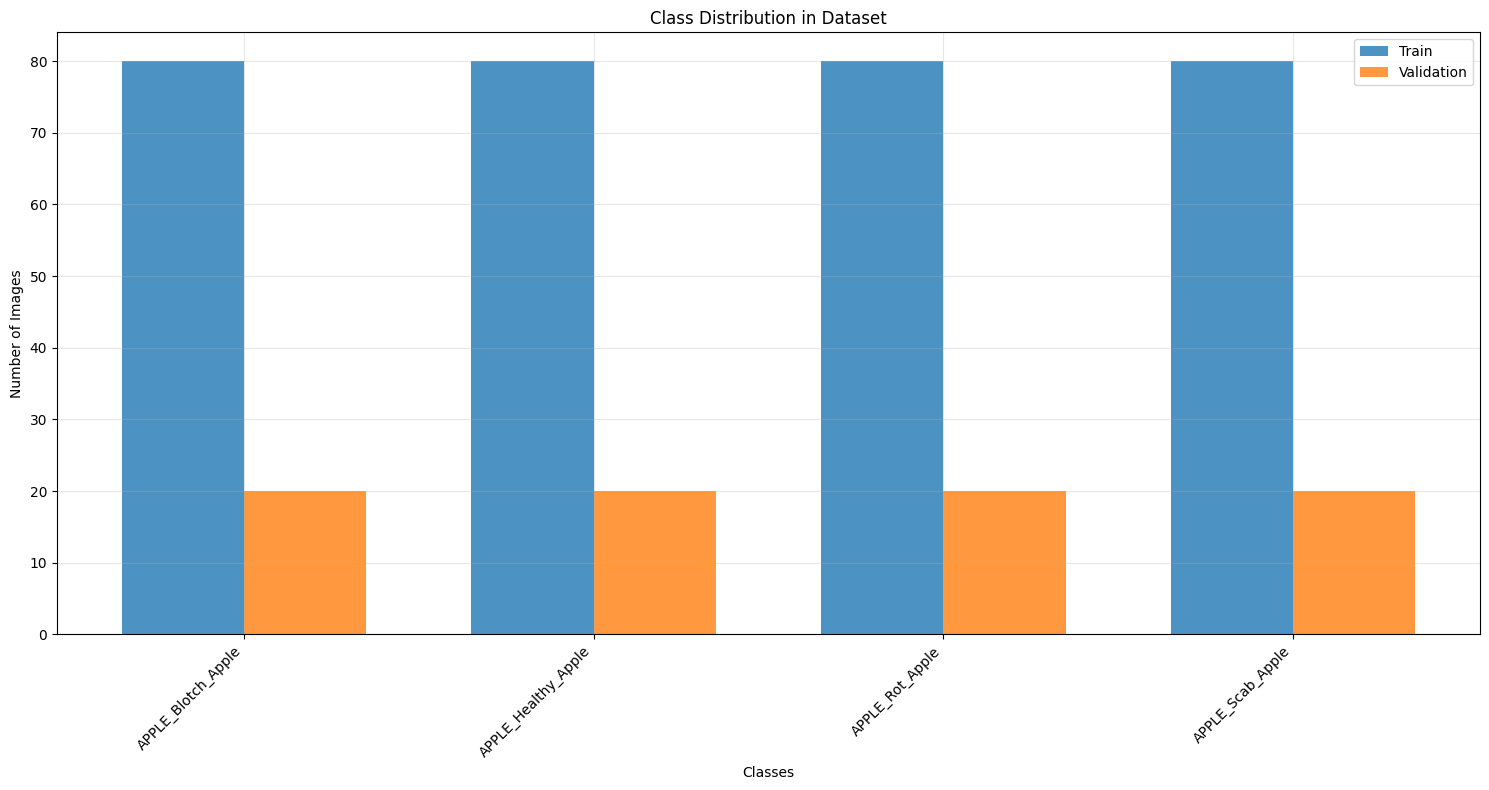

📊 Class distribution plot saved at: yolo11_fruits/results/class_distribution.png


True

In [26]:
# Step 6: Class distribution analysis
analyze_class_distribution()

In [27]:
# Step 7: Train model
model, model_path = train_model(config_path)
if not model or not model_path:
    raise Exception("Model training failed")

🚀 STEP 7: MODEL TRAINING
  • Device: cuda
  • GPU: Tesla T4
  • GPU Memory: 14.7 GB


100%|██████████| 5.35M/5.35M [00:00<00:00, 158MB/s]


  • Mode: Full training (100 epochs)
  • Batch size: 16
  • Image size: 640px
  • Epochs: 100
🔄 Starting training...
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo11_fruits/fruit_config.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fruit_detection, nbs=64, nms=False, o

100%|██████████| 755k/755k [00:00<00:00, 37.2MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 23        [16, 19, 22]  1    431452  ultralytics.nn.modules.head.Detect           [4, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,620 parameters, 2,590,604 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1036.1±504.3 MB/s, size: 43.1 KB)


train: Scanning /content/yolo11_fruits/dataset/labels/train... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<00:00, 2438.90it/s]

train: New cache created: /content/yolo11_fruits/dataset/labels/train.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 358.22it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 651.3±528.4 MB/s, size: 51.5 KB)


val: Scanning /content/yolo11_fruits/dataset/labels/val... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 1287.34it/s]

val: New cache created: /content/yolo11_fruits/dataset/labels/val.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 80/80 [00:00<00:00, 114.40it/s]


Plotting labels to yolo11_fruits/fruit_detection/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolo11_fruits/fruit_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.38G     0.8716      3.253        1.5         52        640: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         80         80    0.00557      0.925     0.0557     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.77G     0.3439      2.984      1.145         49        640: 100%|██████████| 20/20 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


                   all         80         80    0.00662          1      0.271      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.78G     0.2902      2.478      1.064         54        640: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


                   all         80         80      0.156      0.988      0.286      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.79G     0.3305      2.156       1.06         53        640: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         80         80       0.25      0.163      0.233      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.8G     0.3478      2.013       1.04         45        640: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


                   all         80         80      0.242      0.481        0.3      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.81G     0.3383      1.965      1.052         52        640: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         80         80      0.143      0.291      0.195      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.82G     0.3557      1.881      1.061         53        640: 100%|██████████| 20/20 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


                   all         80         80      0.209      0.512      0.285       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.83G     0.3426      1.797      1.034         41        640: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

                   all         80         80      0.197      0.485      0.239      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.84G     0.3443      1.704      1.022         45        640: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]


                   all         80         80      0.082      0.275     0.0737     0.0265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.85G     0.3305      1.688      1.042         53        640: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


                   all         80         80      0.147      0.766      0.204      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.86G     0.3276      1.612      1.019         49        640: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


                   all         80         80      0.279      0.625      0.311      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.87G     0.3003      1.517     0.9978         50        640: 100%|██████████| 20/20 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         80         80      0.272      0.636      0.374      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.88G     0.3117      1.489      1.013         53        640: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


                   all         80         80      0.443        0.7      0.604      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.89G     0.2793      1.477      1.022         49        640: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


                   all         80         80      0.411      0.575      0.525      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.9G     0.3096       1.45     0.9981         44        640: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


                   all         80         80      0.384      0.787      0.576      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.91G     0.2715      1.367     0.9892         53        640: 100%|██████████| 20/20 [00:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


                   all         80         80      0.456      0.375       0.41      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.92G     0.2621      1.347     0.9775         48        640: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


                   all         80         80      0.501      0.639      0.521      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.93G     0.2545      1.315     0.9767         49        640: 100%|██████████| 20/20 [00:04<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         80         80      0.463      0.779      0.597      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.94G     0.2495      1.294     0.9779         50        640: 100%|██████████| 20/20 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         80         80       0.63      0.538      0.663      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.95G     0.2523      1.236      0.975         47        640: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


                   all         80         80      0.251      0.699      0.347      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.96G     0.2672      1.201     0.9755         47        640: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         80         80      0.398      0.574      0.436      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.97G     0.2418      1.233     0.9736         53        640: 100%|██████████| 20/20 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


                   all         80         80      0.641      0.696      0.744      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.98G     0.2401      1.157     0.9524         56        640: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


                   all         80         80      0.553      0.675        0.7      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.99G     0.2326      1.184     0.9591         49        640: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


                   all         80         80      0.518      0.759      0.673      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         3G     0.2421       1.12     0.9499         52        640: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


                   all         80         80      0.672      0.636      0.723      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.01G     0.2089      1.077     0.9378         46        640: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


                   all         80         80      0.744      0.562      0.766      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.02G      0.211      1.035     0.9462         49        640: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


                   all         80         80      0.745      0.861      0.868       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.03G     0.2013      1.057     0.9478         47        640: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         80         80      0.596      0.685      0.646      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.04G     0.2145      1.128     0.9651         49        640: 100%|██████████| 20/20 [00:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


                   all         80         80      0.642       0.61      0.694      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.04G     0.2081      1.063     0.9437         42        640: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         80         80      0.567      0.833      0.721        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.06G     0.2108      1.077     0.9762         44        640: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

                   all         80         80      0.586      0.716      0.684      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.07G     0.2156      1.021     0.9509         43        640: 100%|██████████| 20/20 [00:05<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         80         80      0.575      0.587      0.635      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.08G     0.2087     0.9611     0.9454         53        640: 100%|██████████| 20/20 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         80         80      0.649      0.641      0.698      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.09G     0.2077     0.9955     0.9341         50        640: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


                   all         80         80      0.657      0.687      0.727      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.1G     0.1883     0.9686     0.9508         50        640: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

                   all         80         80      0.713      0.762      0.794      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.11G     0.1872     0.9496     0.9413         48        640: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         80         80      0.577      0.806      0.726      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.12G     0.1897     0.9243     0.9328         41        640: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         80         80      0.707      0.823      0.848      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.12G     0.1688     0.9257     0.9296         50        640: 100%|██████████| 20/20 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         80         80      0.715      0.717      0.782      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.13G     0.1732     0.8941      0.921         47        640: 100%|██████████| 20/20 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

                   all         80         80      0.708      0.881      0.858      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.14G     0.1548     0.8466     0.9308         48        640: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

                   all         80         80      0.657       0.85      0.826      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.15G     0.1558     0.8594     0.9144         56        640: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


                   all         80         80      0.775       0.74      0.839      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.16G     0.1629     0.8941     0.9519         49        640: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         80         80      0.723      0.795      0.811      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.18G     0.1675     0.8551     0.9271         49        640: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         80         80      0.805      0.756      0.848      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.19G     0.1593     0.8762     0.9341         51        640: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         80         80      0.719      0.773      0.817      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       3.2G     0.1491     0.8432      0.914         54        640: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         80         80      0.749      0.622       0.76      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.21G     0.1585     0.8185      0.928         53        640: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         80         80      0.649      0.785      0.789      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.21G     0.1545     0.8365     0.9233         46        640: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         80         80      0.733       0.83      0.841      0.811
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 27, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



47 epochs completed in 0.087 hours.
Optimizer stripped from yolo11_fruits/fruit_detection/weights/last.pt, 5.5MB
Optimizer stripped from yolo11_fruits/fruit_detection/weights/best.pt, 5.5MB

Validating yolo11_fruits/fruit_detection/weights/best.pt...
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


                   all         80         80      0.744      0.862      0.866      0.848
    APPLE_Blotch_Apple         20         20      0.794       0.75      0.874      0.867
   APPLE_Healthy_Apple         20         20        0.8        0.8      0.833      0.817
       APPLE_Rot_Apple         20         20      0.944        0.9      0.939        0.9
      APPLE_Scab_Apple         20         20       0.44          1      0.819      0.809
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 6.0ms postprocess per image
Saving yolo11_fruits/fruit_detection/predictions.json...
Results saved to yolo11_fruits/fruit_detection
✅ Training complete! Model saved at: yolo11_fruits/fruit_detection/weights/best.pt


📈 STEP 8: VISUALIZE TRAINING METRICS


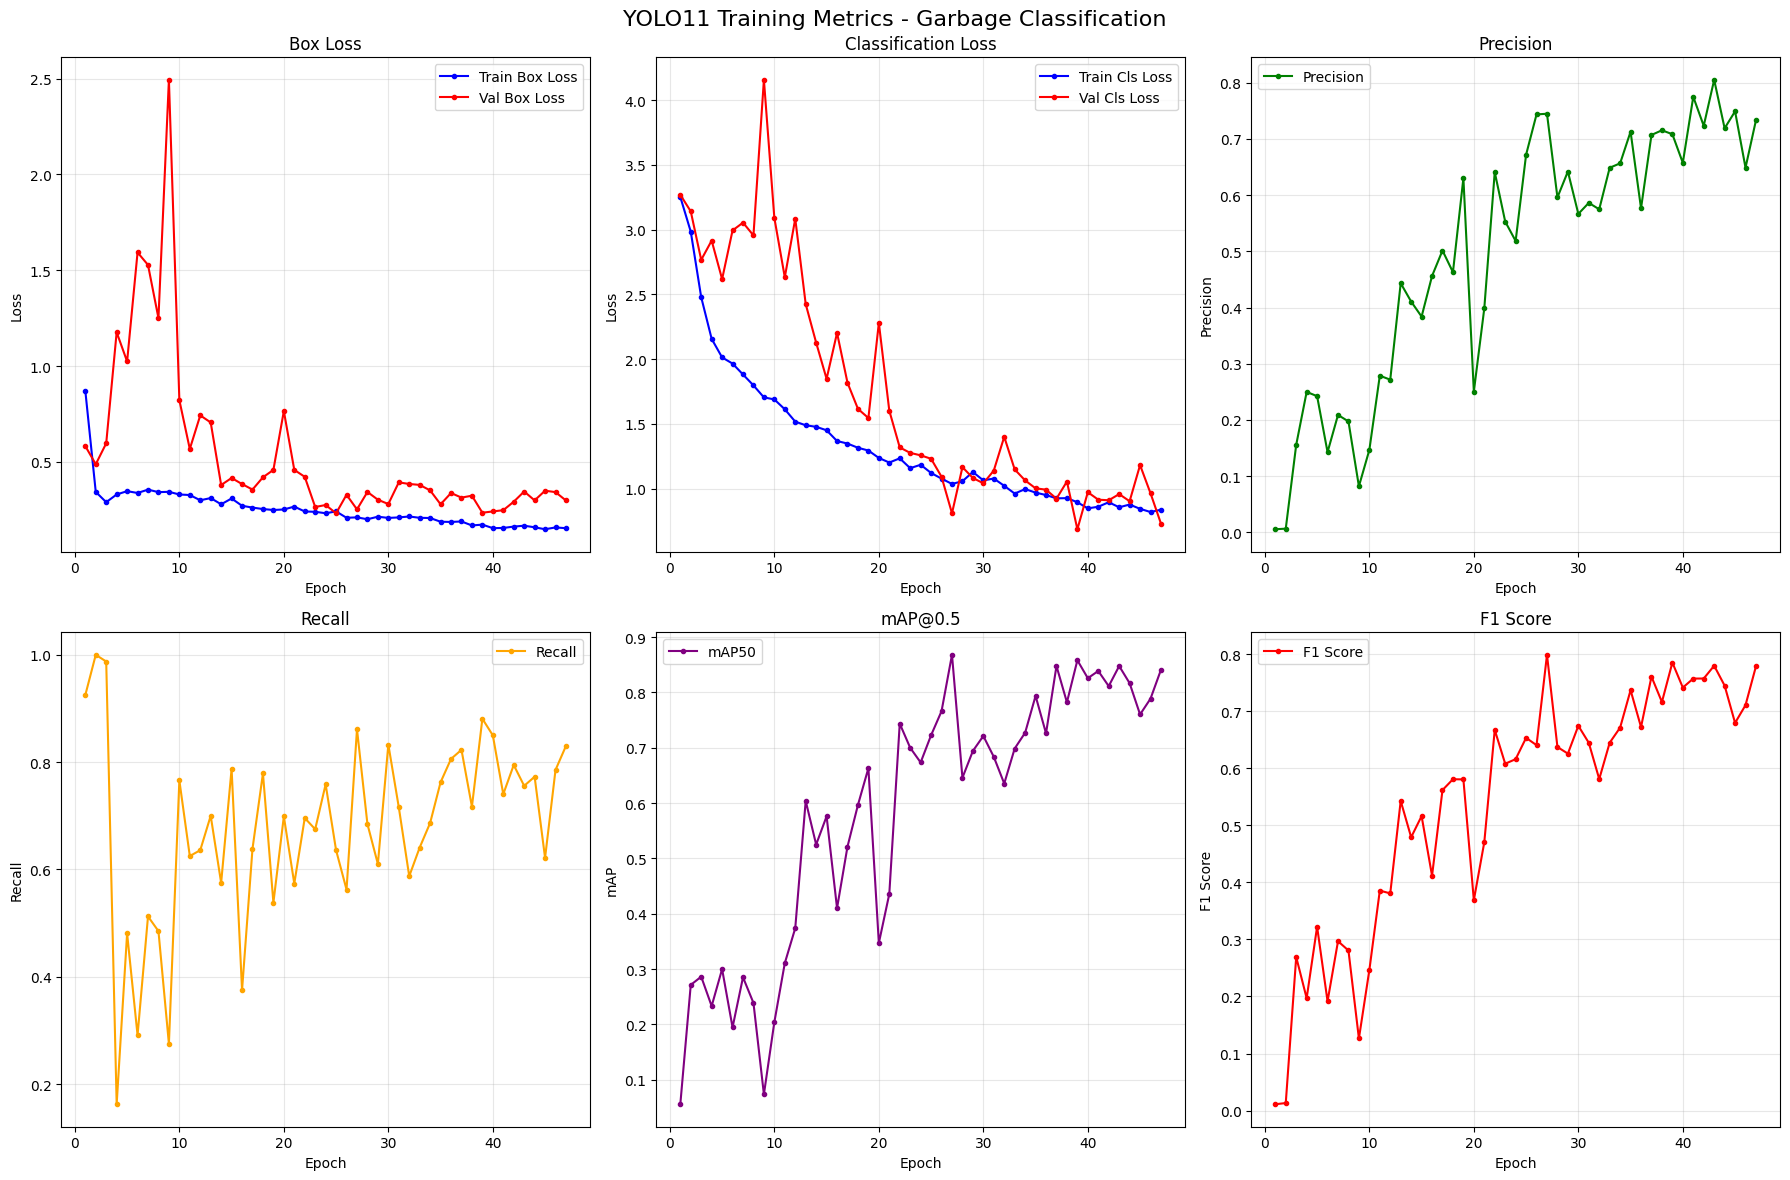

📊 Metric plots saved at: yolo11_fruits/results/training_metrics.png

📈 Final metrics (Epoch 47):
  • Precision: 0.7333
  • Recall: 0.8302
  • mAP50: 0.8408
  • mAP50-95: 0.8108


True

In [28]:
# Step 8: Visualize training metrics
visualize_training_metrics()

In [29]:
# Step 9: Evaluate model
evaluate_model(model_path, config_path)

🔍 STEP 9: MODEL EVALUATION
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1322.9±311.7 MB/s, size: 52.6 KB)


val: Scanning /content/yolo11_fruits/dataset/labels/val.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


                   all         80         80      0.745      0.863      0.866      0.848
    APPLE_Blotch_Apple         20         20      0.793       0.75      0.874      0.867
   APPLE_Healthy_Apple         20         20      0.797        0.8      0.833      0.817
       APPLE_Rot_Apple         20         20      0.947        0.9      0.939      0.899
      APPLE_Scab_Apple         20         20      0.441          1      0.819      0.809
Speed: 4.3ms preprocess, 10.2ms inference, 0.1ms loss, 3.3ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val
📊 Evaluation results:
  • mAP50: 0.8660
  • mAP50-95: 0.8479
  • Precision: 0.7445
  • Recall: 0.8625


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e830fe75a90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

🎨 STEP 10: PREDICTION VISUALIZATION


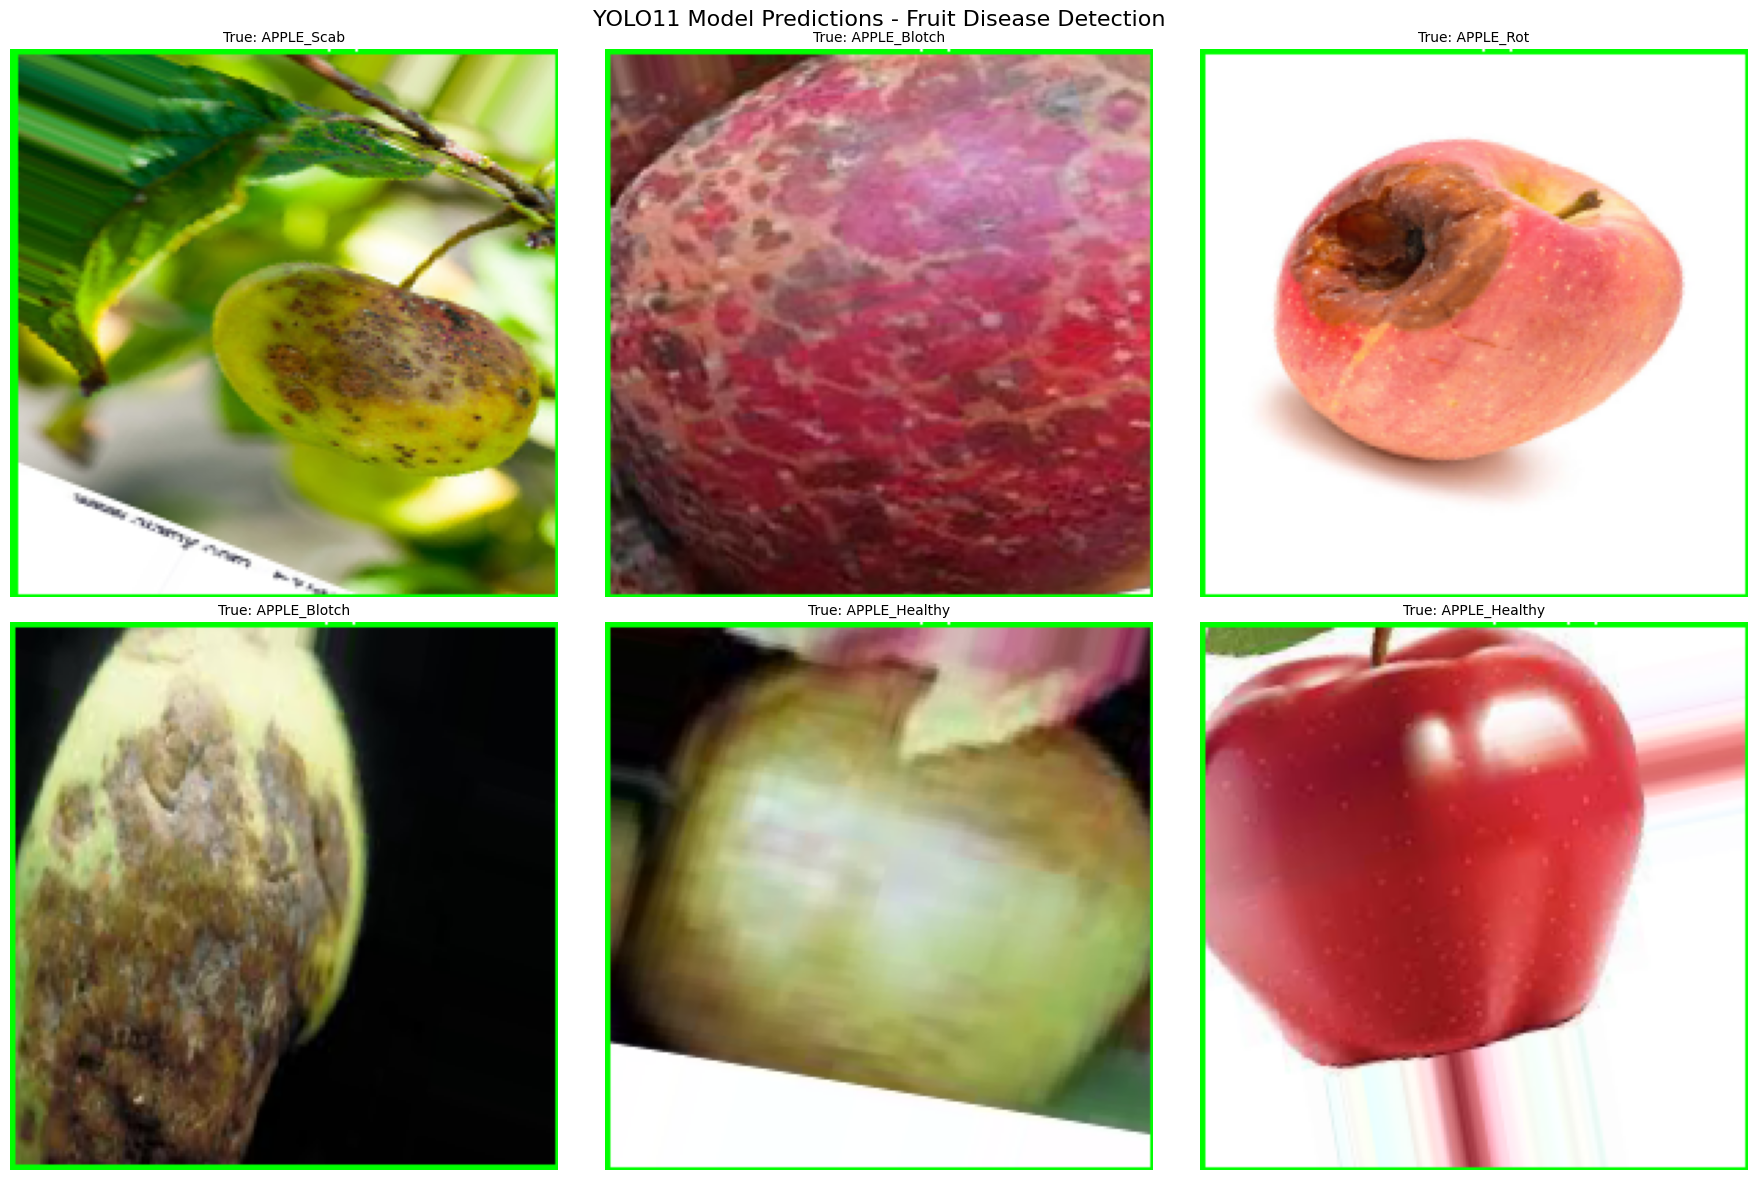

🎨 Visualizations saved to: yolo11_fruits/results/predictions_visualization.png


True

In [30]:
# Step 10: Visualize predictions
visualize_predictions(model_path)

In [31]:
# Step 11: Inference demo
inference_demo(model_path)

🎯 STEP 11: INFERENCE DEMONSTRATION
🖼️  Processing 10 sample images...

🖼️  Image 1: APPLE_Scab_Apple__0_591.jpg
   📋 True class: APPLE_Scab_Apple
   🎯 Prediction: APPLE_Scab_Apple (confidence: 0.868)
   📊 Status: ✅ CORRECT

🖼️  Image 2: APPLE_Blotch_Apple__0_610.jpg
   📋 True class: APPLE_Blotch_Apple
   🎯 Prediction: APPLE_Scab_Apple (confidence: 0.880)
   📊 Status: ❌ INCORRECT

🖼️  Image 3: APPLE_Rot_Apple__0_200.jpg
   📋 True class: APPLE_Rot_Apple
   🎯 Prediction: APPLE_Rot_Apple (confidence: 0.606)
   📊 Status: ✅ CORRECT

🖼️  Image 4: APPLE_Blotch_Apple__0_529.jpg
   📋 True class: APPLE_Blotch_Apple
   🎯 Prediction: APPLE_Scab_Apple (confidence: 0.602)
   📊 Status: ❌ INCORRECT

🖼️  Image 5: APPLE_Healthy_Apple__0_497.jpg
   📋 True class: APPLE_Healthy_Apple
   🎯 Prediction: APPLE_Scab_Apple (confidence: 0.626)
   📊 Status: ❌ INCORRECT

🖼️  Image 6: APPLE_Healthy_Apple__0_1234.jpg
   📋 True class: APPLE_Healthy_Apple
   🎯 Prediction: APPLE_Healthy_Apple (confidence: 0.841)
   📊 Sta

image           true_class           prediction  \
0      APPLE_Scab_Apple__0_591.jpg     APPLE_Scab_Apple     APPLE_Scab_Apple   
1    APPLE_Blotch_Apple__0_610.jpg   APPLE_Blotch_Apple     APPLE_Scab_Apple   
2       APPLE_Rot_Apple__0_200.jpg      APPLE_Rot_Apple      APPLE_Rot_Apple   
3    APPLE_Blotch_Apple__0_529.jpg   APPLE_Blotch_Apple     APPLE_Scab_Apple   
4   APPLE_Healthy_Apple__0_497.jpg  APPLE_Healthy_Apple     APPLE_Scab_Apple   
5  APPLE_Healthy_Apple__0_1234.jpg  APPLE_Healthy_Apple  APPLE_Healthy_Apple   
6       APPLE_Rot_Apple__0_279.jpg      APPLE_Rot_Apple      APPLE_Rot_Apple   
7       APPLE_Rot_Apple__0_412.jpg      APPLE_Rot_Apple      APPLE_Rot_Apple   
8       APPLE_Rot_Apple__0_420.jpg      APPLE_Rot_Apple      APPLE_Rot_Apple   
9      APPLE_Scab_Apple__0_854.jpg     APPLE_Scab_Apple     APPLE_Scab_Apple   

   confidence  correct  
0    0.868458     True  
1    0.880470    False  
2    0.606250     True  
3    0.601659    False  
4    0.626392    False  
5    0.840986     True  
6    0.669262     True  
7    0.763391     True  
8    0.542368     True  
9    0.879908     True

📊 STEP 12: CONFUSION MATRIX
🔄 Processing 80 images...


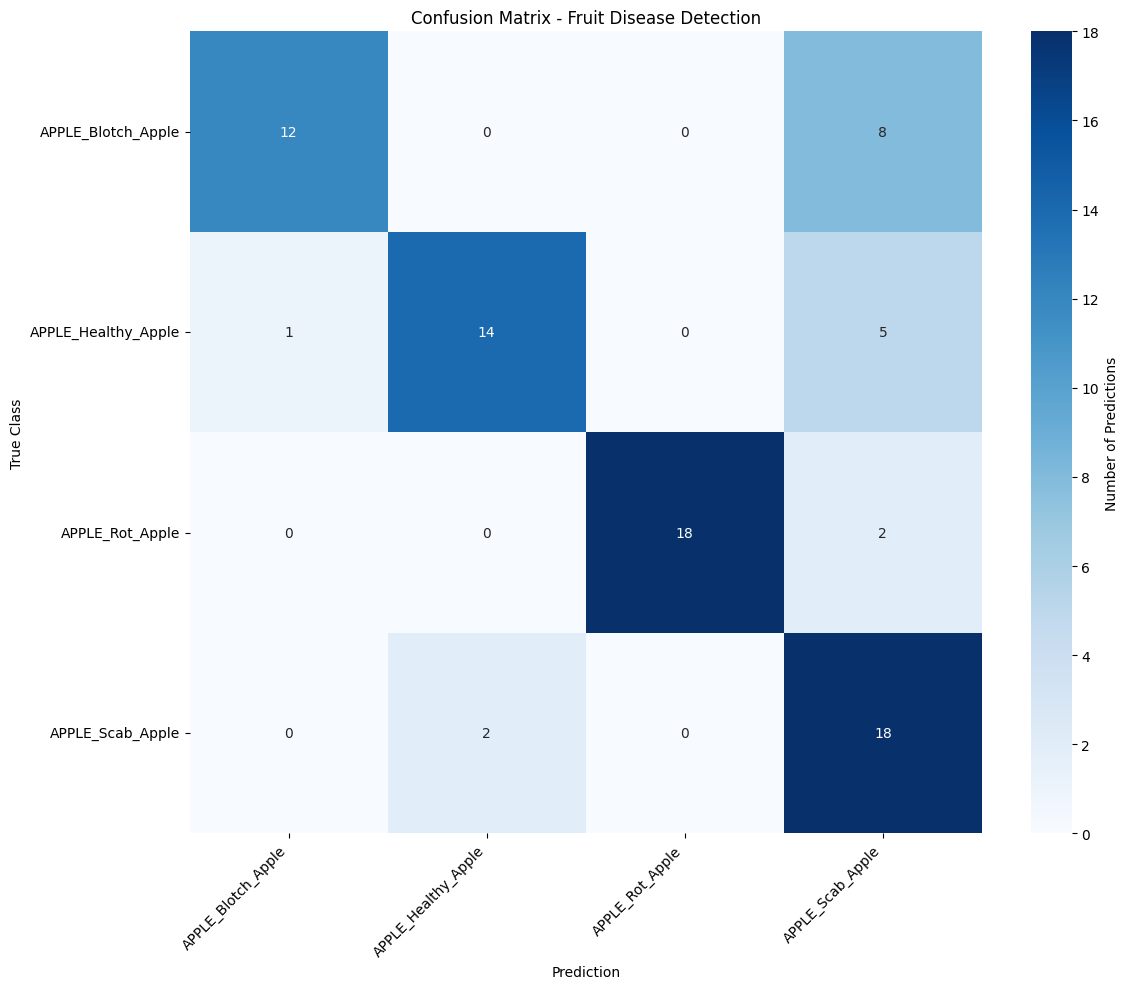


📈 CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
Class                Precision  Recall     F1-Score   Support   
--------------------------------------------------------------------------------
APPLE_Blotch_Apple   0.923      0.600      0.727      20        
APPLE_Healthy_Apple  0.875      0.700      0.778      20        
APPLE_Rot_Apple      1.000      0.900      0.947      20        
APPLE_Scab_Apple     0.545      0.900      0.679      20        
--------------------------------------------------------------------------------
Macro Avg            0.836      0.775      0.783      80        

💾 Confusion matrix saved at: yolo11_fruits/results/confusion_matrix.png
💾 Classification report saved at: yolo11_fruits/results/classification_report.json


True

In [32]:
# Step 12: Confusion matrix
build_confusion_matrix(model_path)

🔍 STEP 13: ERROR ANALYSIS
🔄 Analyzing 80 predictions...
📊 ERROR SUMMARY:
   ✅ Correct predictions: 62
   ❌ Errors: 18
   🎯 Accuracy: 77.5%

🔍 MOST COMMON ERRORS:
   • APPLE_Blotch_Apple -> APPLE_Scab_Apple: 8 cases
   • APPLE_Healthy_Apple -> APPLE_Scab_Apple: 5 cases
   • APPLE_Scab_Apple -> APPLE_Healthy_Apple: 2 cases
   • APPLE_Rot_Apple -> APPLE_Scab_Apple: 2 cases
   • APPLE_Healthy_Apple -> APPLE_Blotch_Apple: 1 cases

📈 CONFIDENCE ANALYSIS IN ERRORS:
   • Average confidence in errors: 0.708
   • High confidence errors (>0.7): 10


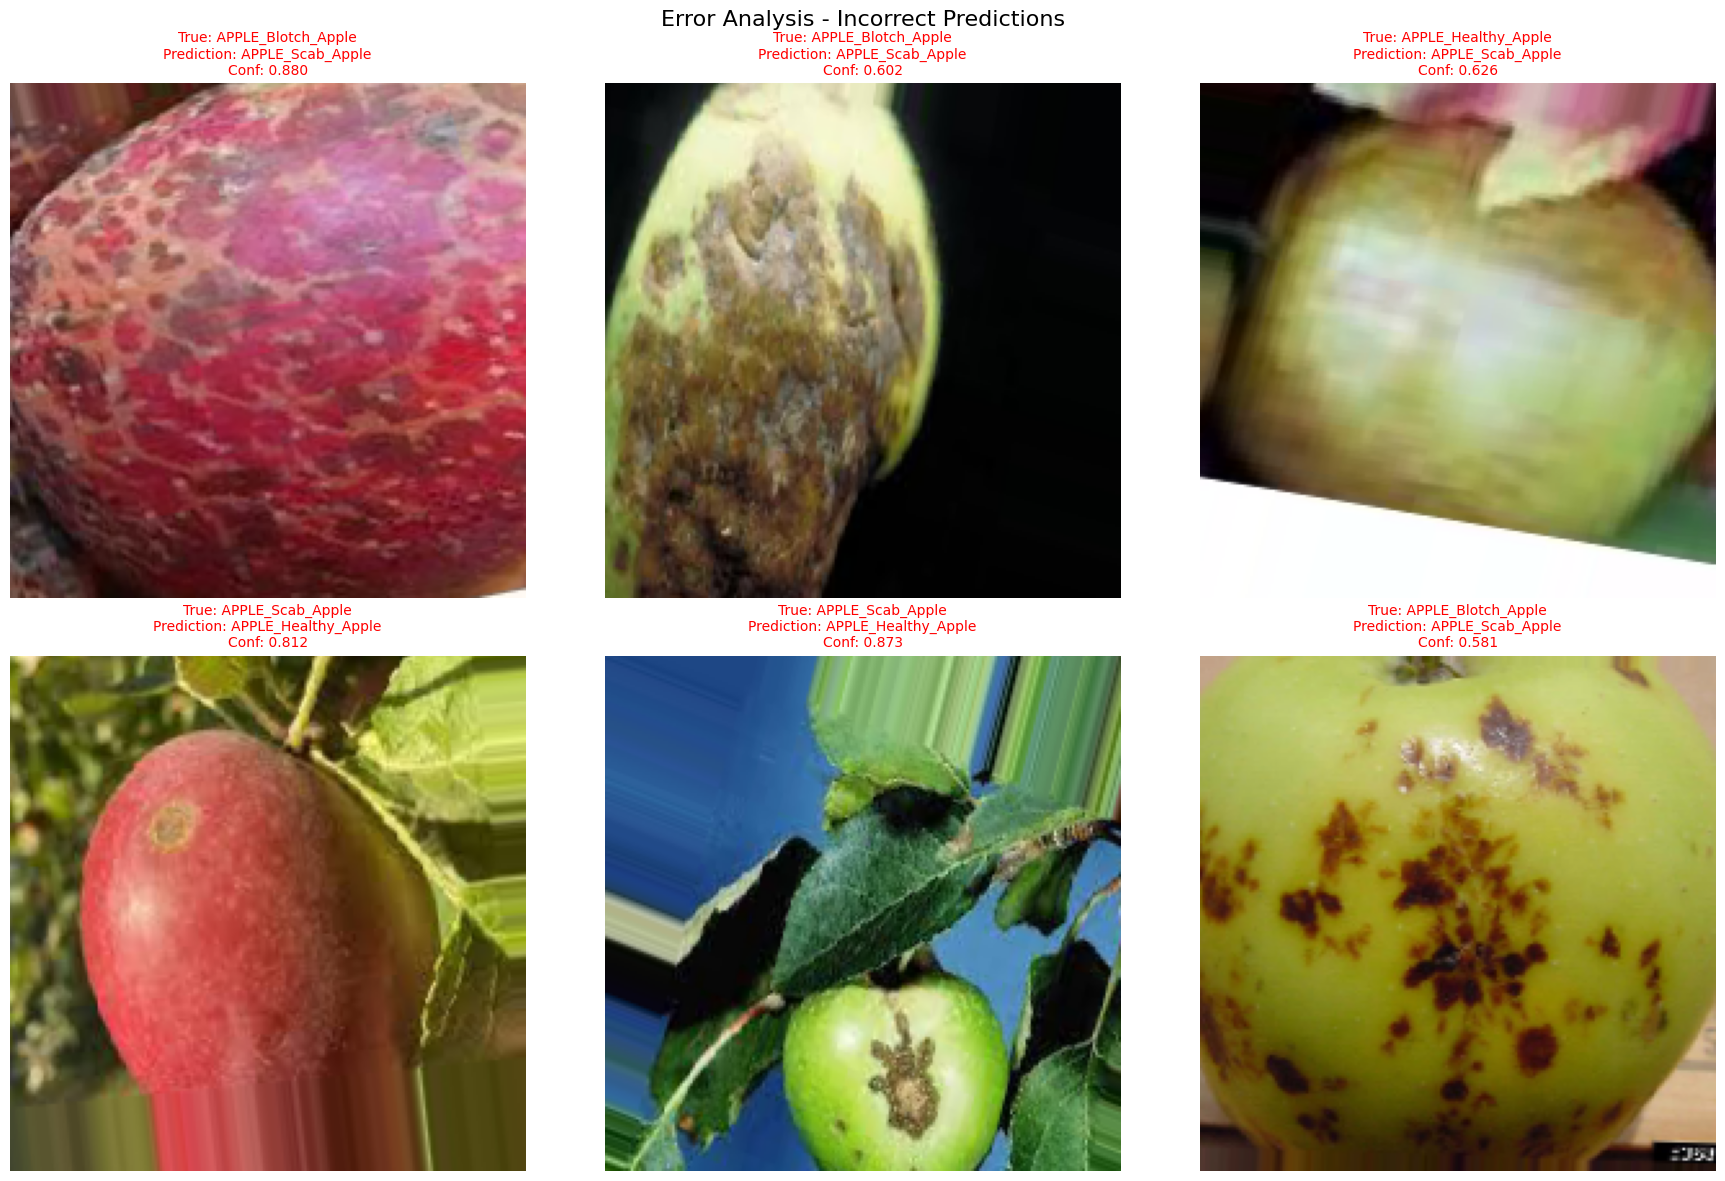

🎨 Error visualization saved at: yolo11_fruits/results/error_analysis_visualization.png

💾 Error analysis saved at: yolo11_fruits/results/error_analysis.json


True

In [33]:
# Step 13: Error analysis
error_analysis(model_path)

In [34]:
# Step 14: Final report
final_report()

📋 STEP 14: FINAL REPORT
🎉 PROJECT COMPLETED
📋 Final report generated:
   • Markdown: yolo11_fruits/results/final_report.md
   • JSON: yolo11_fruits/results/final_report.json

📊 Final model metrics:
   • mAP@0.5: 84.1%
   • Precision: 73.3%
   • Recall: 83.0%

📁 All files are located at: yolo11_fruits
🎯 The trained model is ready to use!


True

### 🔄 Option 2: Full Pipeline Execution
Run the entire pipeline automatically by executing the `run_full_pipeline()` function. This will execute all 14 steps sequentially:

```python
# Execute the complete pipeline
run_full_pipeline()
```

In [35]:
# ============================================================================
# MAIN FUNCTION TO RUN THE ENTIRE PIPELINE
# ============================================================================
def run_full_pipeline():
    """Run the entire training pipeline"""
    print("🚀 STARTING FULL YOLO11 PIPELINE - FRUIT DETECTION")
    print("=" * 60)

    # Step 1: Initial setup
    if not initial_setup():
        return False

    # Step 2: Download dataset
    dataset_path = download_dataset()
    if not dataset_path:
        return False

    # Step 3: Explore dataset
    if not explore_dataset(dataset_path):
        return False

    # Step 4: Prepare data
    success, train_count, val_count = prepare_data_yolo(dataset_path)
    if not success:
        return False

    # Step 5: Create configuration
    config_path = create_config_file()
    if not config_path:
        return False

    # Step 6: Class distribution analysis
    analyze_class_distribution()

    # Step 7: Train model
    model, model_path = train_model(config_path)
    if not model or not model_path:
        return False

    # Step 8: Visualize training metrics
    visualize_training_metrics()

    # Step 9: Evaluate model
    evaluate_model(model_path, config_path)

    # Step 10: Visualize predictions
    visualize_predictions(model_path)

    # Step 11: Inference demo
    inference_demo(model_path)

    # Step 12: Confusion matrix
    build_confusion_matrix(model_path)

    # Step 13: Error analysis
    error_analysis(model_path)

    # Step 14: Final report
    final_report()

    print("\n🎉 PIPELINE SUCCESSFULLY COMPLETED!")
    print("=" * 60)

    return True

🚀 STARTING FULL YOLO11 PIPELINE - FRUIT DETECTION
📁 Directories created in: yolo11_fruits
✅ Initial setup completed

📥 STEP 2: DOWNLOAD THE DATASET
/root/.cache/kagglehub/datasets/ateebnoone/fruits-dataset-for-fruit-disease-classification/versions/2/
✅ Dataset already downloaded at: /root/.cache/kagglehub/datasets/ateebnoone/fruits-dataset-for-fruit-disease-classification/versions/2/
🔍 STEP 3: DATASET EXPLORATION
📁 Dataset structure at: /root/.cache/kagglehub/datasets/ateebnoone/fruits-dataset-for-fruit-disease-classification/versions/2/
/
MANGO/
  Black Mould Rot (Aspergillus)_Mango/
    Aspergillus_116.jpg
    Aspergillus_090.jpg
    Aspergillus_047.jpg
    ... and 179 more files
  Alternaria_Mango/
    Alternaria_128.jpg
    Alternaria_163.jpg
    Alternaria_168.jpg
    ... and 112 more files
  Stem and Rot (Lasiodiplodia)_Mango/
    Lasiodiplodia_094.jpg
    Lasiodiplodia_009.jpg
    Lasiodiplodia_002.jpg
    ... and 154 more files
  Anthracnose_Mango/
    Anthracnose_062.jpg
    A

100%|██████████| 80/80 [00:00<00:00, 420.85it/s]


  ✅ Train: 320 images processed
  ✅ Val: 80 images processed
  📁 Files created:
    Train: 320 images, 320 labels
    Val: 80 images, 80 labels

🔍 Checking labels...
  • Maximum class found in labels: 3
  • Valid classes: 0–3
📝 STEP 5: CREATE YAML CONFIGURATION FILE
✅ Configuration saved at: yolo11_fruits/fruit_config.yaml
  • Number of classes: 4
  • Classes: APPLE_Blotch_Apple, APPLE_Healthy_Apple, APPLE_Rot_Apple, APPLE_Scab_Apple
📊 STEP 6: CLASS DISTRIBUTION ANALYSIS


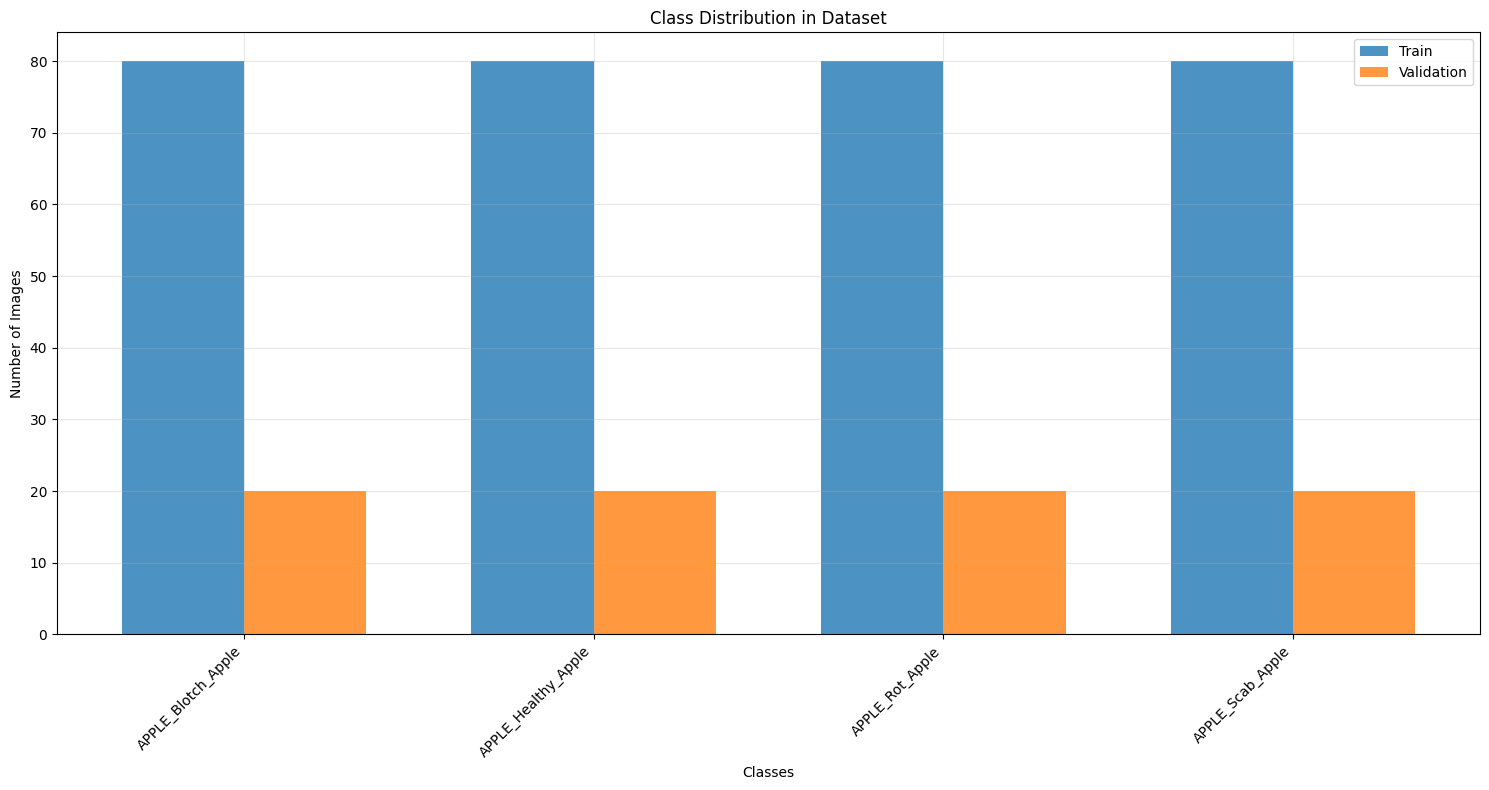

📊 Class distribution plot saved at: yolo11_fruits/results/class_distribution.png
🚀 STEP 7: MODEL TRAINING
  • Device: cuda
  • GPU: Tesla T4
  • GPU Memory: 14.7 GB
  • Mode: Full training (100 epochs)
  • Batch size: 16
  • Image size: 640px
  • Epochs: 100
🔄 Starting training...
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo11_fruits/fruit_config.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lr

train: Scanning /content/yolo11_fruits/dataset/labels/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.4GB RAM): 100%|██████████| 320/320 [00:00<00:00, 364.56it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 345.7±58.8 MB/s, size: 51.5 KB)


val: Scanning /content/yolo11_fruits/dataset/labels/val.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 80/80 [00:00<00:00, 129.65it/s]


Plotting labels to yolo11_fruits/fruit_detection/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolo11_fruits/fruit_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.46G     0.8716      3.253        1.5         52        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


                   all         80         80    0.00557      0.925     0.0557     0.0295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.62G     0.3439      2.984      1.145         49        640: 100%|██████████| 20/20 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all         80         80    0.00662          1      0.271      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.62G     0.2902      2.478      1.064         54        640: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         80         80      0.156      0.988      0.286      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.62G     0.3305      2.156       1.06         53        640: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


                   all         80         80       0.25      0.163      0.233      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.62G     0.3478      2.013       1.04         45        640: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         80         80      0.242      0.481        0.3      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.62G     0.3383      1.965      1.052         52        640: 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         80         80      0.143      0.291      0.195      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.62G     0.3557      1.881      1.061         53        640: 100%|██████████| 20/20 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         80         80      0.209      0.512      0.285       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.62G     0.3426      1.797      1.034         41        640: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         80         80      0.197      0.485      0.239      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.62G     0.3443      1.704      1.022         45        640: 100%|██████████| 20/20 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         80         80      0.082      0.275     0.0737     0.0265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.62G     0.3305      1.688      1.042         53        640: 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


                   all         80         80      0.147      0.766      0.204      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.62G     0.3276      1.612      1.019         49        640: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         80         80      0.279      0.625      0.311      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.62G     0.3003      1.517     0.9978         50        640: 100%|██████████| 20/20 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

                   all         80         80      0.272      0.636      0.374      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.62G     0.3117      1.489      1.013         53        640: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         80         80      0.443        0.7      0.604      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.62G     0.2793      1.477      1.022         49        640: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


                   all         80         80      0.411      0.575      0.525      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.62G     0.3096       1.45     0.9981         44        640: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

                   all         80         80      0.384      0.787      0.576      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.62G     0.2715      1.367     0.9892         53        640: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         80         80      0.456      0.375       0.41      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.62G     0.2621      1.347     0.9775         48        640: 100%|██████████| 20/20 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         80         80      0.501      0.639      0.521      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.62G     0.2545      1.315     0.9767         49        640: 100%|██████████| 20/20 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         80         80      0.463      0.779      0.597      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.62G     0.2495      1.294     0.9779         50        640: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         80         80       0.63      0.538      0.663      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.62G     0.2523      1.236      0.975         47        640: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

                   all         80         80      0.251      0.699      0.347      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.62G     0.2672      1.201     0.9755         47        640: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


                   all         80         80      0.398      0.574      0.436      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.62G     0.2418      1.233     0.9736         53        640: 100%|██████████| 20/20 [00:06<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         80         80      0.641      0.696      0.744      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.62G     0.2401      1.157     0.9524         56        640: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         80         80      0.553      0.675        0.7      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.62G     0.2326      1.184     0.9591         49        640: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         80         80      0.518      0.759      0.673      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.62G     0.2421       1.12     0.9499         52        640: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


                   all         80         80      0.672      0.636      0.723      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.62G     0.2089      1.077     0.9378         46        640: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         80         80      0.744      0.562      0.766      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.62G      0.211      1.035     0.9462         49        640: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         80         80      0.745      0.861      0.868       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.62G     0.2013      1.057     0.9478         47        640: 100%|██████████| 20/20 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         80         80      0.596      0.685      0.646      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.62G     0.2145      1.128     0.9651         49        640: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         80         80      0.642       0.61      0.694      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.62G     0.2081      1.063     0.9437         42        640: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         80         80      0.567      0.833      0.721        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.62G     0.2108      1.077     0.9762         44        640: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         80         80      0.586      0.716      0.684      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.62G     0.2156      1.021     0.9509         43        640: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         80         80      0.575      0.587      0.635      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.62G     0.2087     0.9611     0.9454         53        640: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         80         80      0.649      0.641      0.698      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.62G     0.2077     0.9955     0.9341         50        640: 100%|██████████| 20/20 [00:04<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         80         80      0.657      0.687      0.727      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.62G     0.1883     0.9686     0.9508         50        640: 100%|██████████| 20/20 [00:06<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         80         80      0.713      0.762      0.794      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.62G     0.1872     0.9496     0.9413         48        640: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

                   all         80         80      0.577      0.806      0.726      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.62G     0.1897     0.9243     0.9328         41        640: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         80         80      0.707      0.823      0.848      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.62G     0.1688     0.9257     0.9296         50        640: 100%|██████████| 20/20 [00:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         80         80      0.715      0.717      0.782      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.62G     0.1732     0.8941      0.921         47        640: 100%|██████████| 20/20 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         80         80      0.708      0.881      0.858      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.62G     0.1548     0.8466     0.9308         48        640: 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all         80         80      0.657       0.85      0.826      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.62G     0.1558     0.8594     0.9144         56        640: 100%|██████████| 20/20 [00:05<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         80         80      0.775       0.74      0.839      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.62G     0.1629     0.8941     0.9519         49        640: 100%|██████████| 20/20 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         80         80      0.723      0.795      0.811      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.62G     0.1675     0.8551     0.9271         49        640: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         80         80      0.805      0.756      0.848      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.62G     0.1593     0.8762     0.9341         51        640: 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         80         80      0.719      0.773      0.817      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.62G     0.1491     0.8432      0.914         54        640: 100%|██████████| 20/20 [00:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         80         80      0.749      0.622       0.76      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.62G     0.1585     0.8185      0.928         53        640: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         80         80      0.649      0.785      0.789      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.62G     0.1545     0.8365     0.9233         46        640: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

                   all         80         80      0.733       0.83      0.841      0.811
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 27, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



47 epochs completed in 0.089 hours.
Optimizer stripped from yolo11_fruits/fruit_detection/weights/last.pt, 5.5MB
Optimizer stripped from yolo11_fruits/fruit_detection/weights/best.pt, 5.5MB

Validating yolo11_fruits/fruit_detection/weights/best.pt...
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


                   all         80         80      0.744      0.862      0.866      0.848
    APPLE_Blotch_Apple         20         20      0.794       0.75      0.874      0.867
   APPLE_Healthy_Apple         20         20        0.8        0.8      0.833      0.817
       APPLE_Rot_Apple         20         20      0.944        0.9      0.939        0.9
      APPLE_Scab_Apple         20         20       0.44          1      0.819      0.809
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 5.5ms postprocess per image
Saving yolo11_fruits/fruit_detection/predictions.json...
Results saved to yolo11_fruits/fruit_detection
✅ Training complete! Model saved at: yolo11_fruits/fruit_detection/weights/best.pt
📈 STEP 8: VISUALIZE TRAINING METRICS


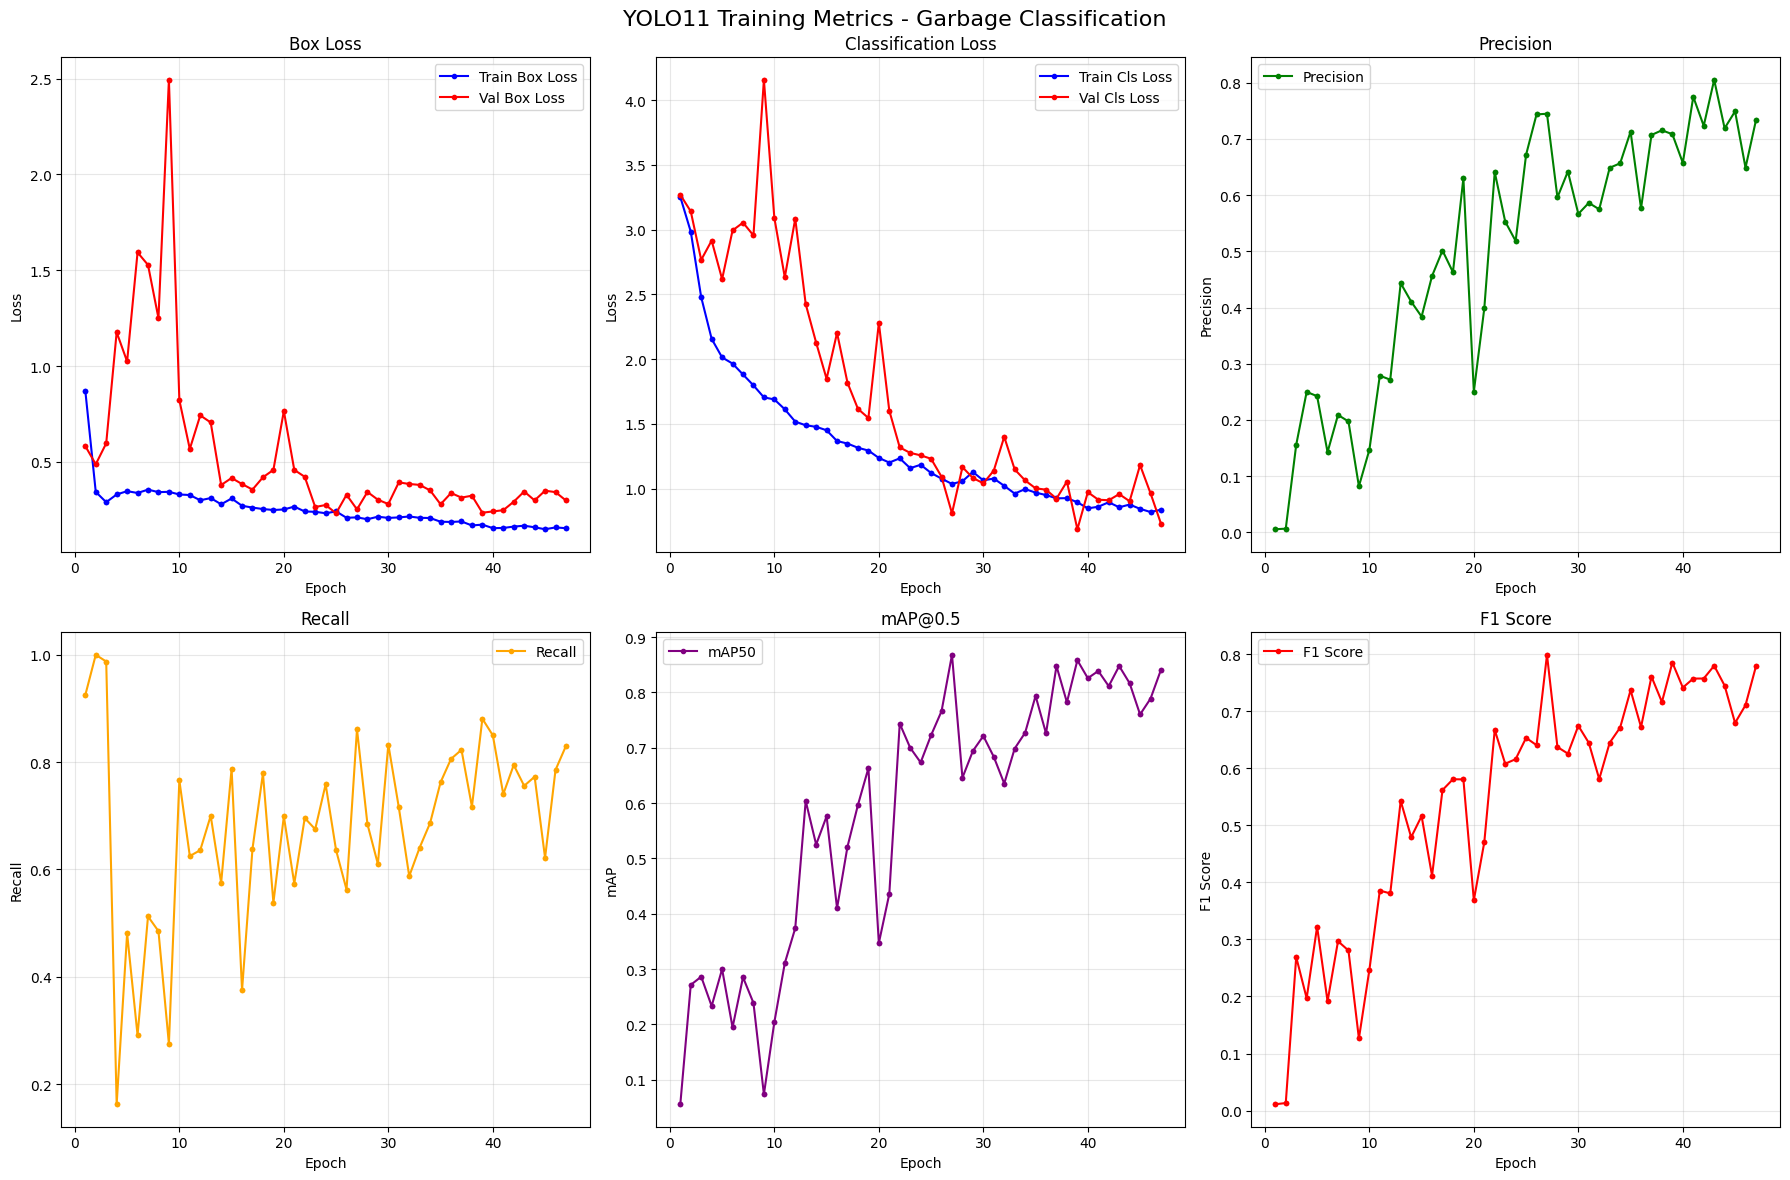

📊 Metric plots saved at: yolo11_fruits/results/training_metrics.png

📈 Final metrics (Epoch 47):
  • Precision: 0.7333
  • Recall: 0.8302
  • mAP50: 0.8408
  • mAP50-95: 0.8108
🔍 STEP 9: MODEL EVALUATION
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 924.3±226.8 MB/s, size: 52.6 KB)


val: Scanning /content/yolo11_fruits/dataset/labels/val.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


                   all         80         80      0.745      0.863      0.866      0.848
    APPLE_Blotch_Apple         20         20      0.793       0.75      0.874      0.867
   APPLE_Healthy_Apple         20         20      0.797        0.8      0.833      0.817
       APPLE_Rot_Apple         20         20      0.947        0.9      0.939      0.899
      APPLE_Scab_Apple         20         20      0.441          1      0.819      0.809
Speed: 3.5ms preprocess, 6.0ms inference, 0.0ms loss, 8.0ms postprocess per image
Saving runs/detect/val2/predictions.json...
Results saved to runs/detect/val2
📊 Evaluation results:
  • mAP50: 0.8660
  • mAP50-95: 0.8479
  • Precision: 0.7445
  • Recall: 0.8625
🎨 STEP 10: PREDICTION VISUALIZATION


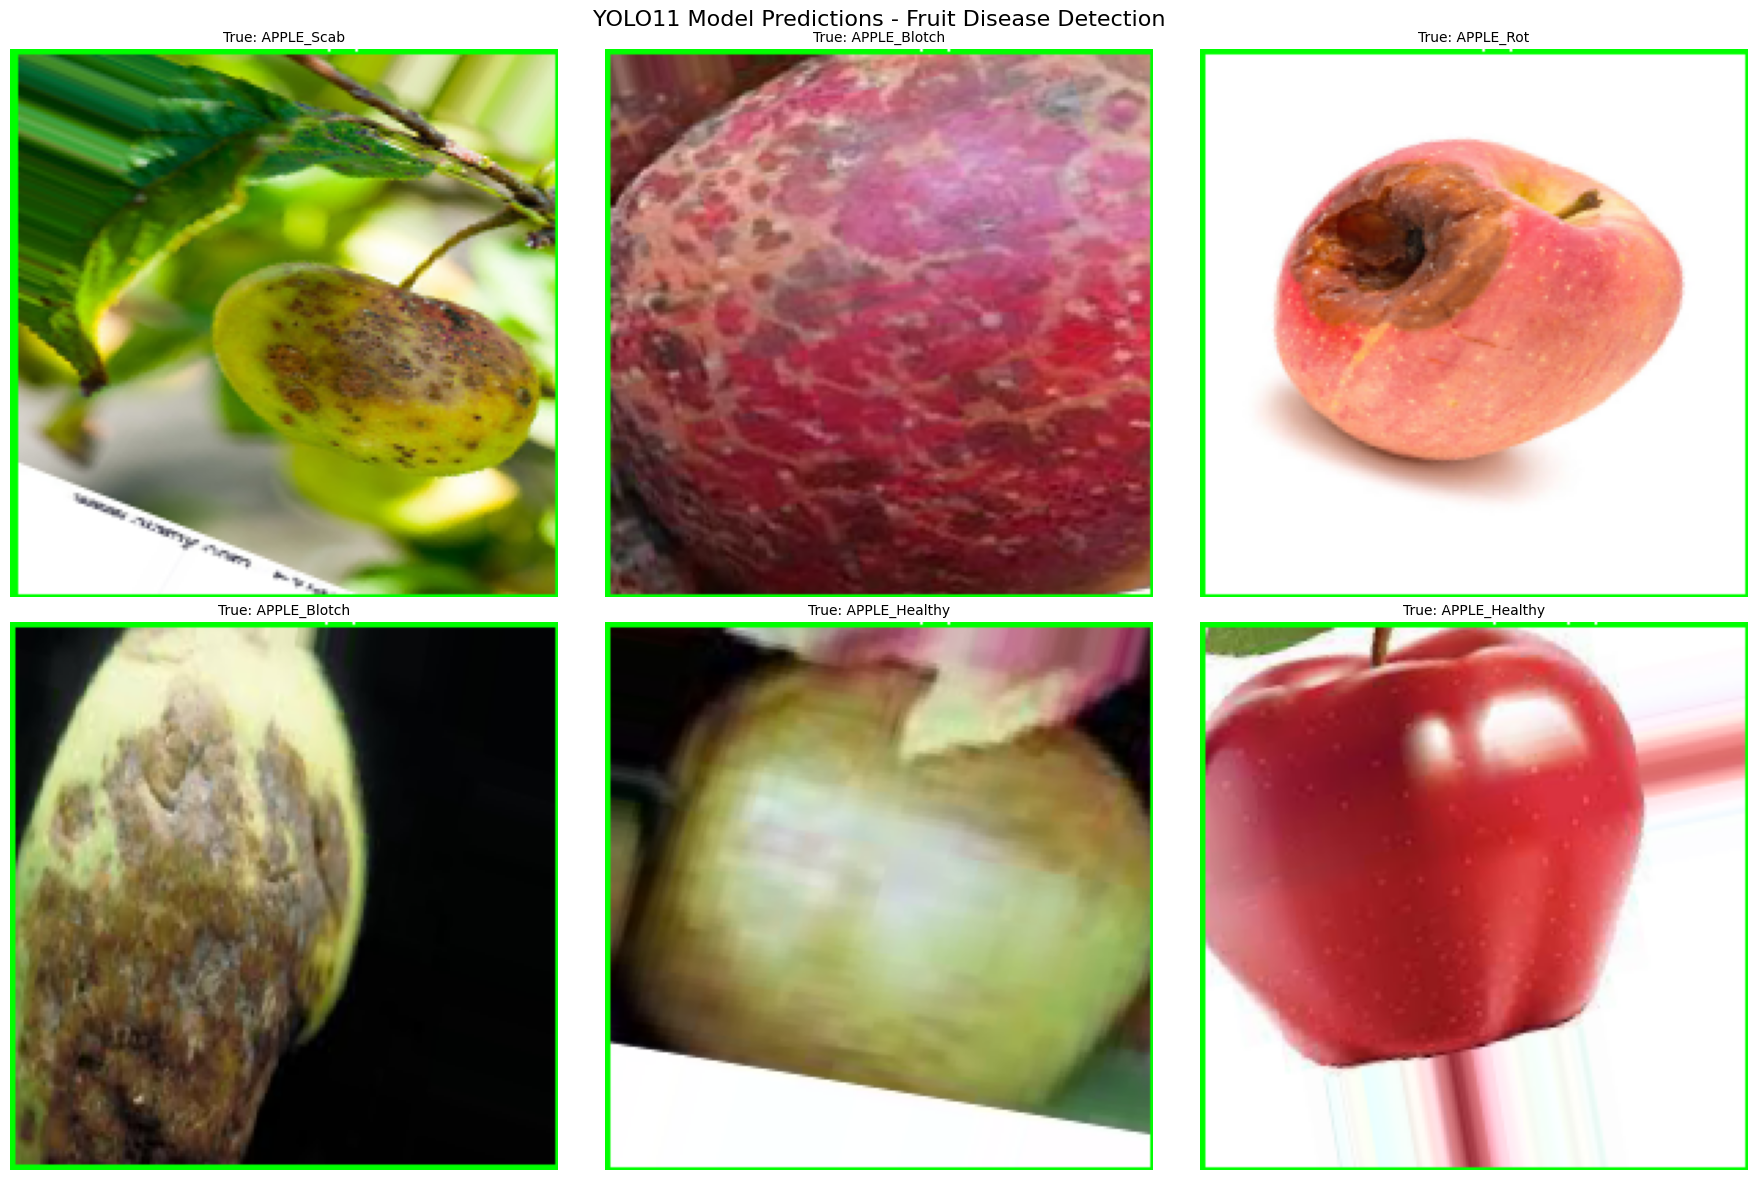

🎨 Visualizations saved to: yolo11_fruits/results/predictions_visualization.png
🎯 STEP 11: INFERENCE DEMONSTRATION
🖼️  Processing 10 sample images...

🖼️  Image 1: APPLE_Scab_Apple__0_591.jpg
   📋 True class: APPLE_Scab_Apple
   🎯 Prediction: APPLE_Scab_Apple (confidence: 0.868)
   📊 Status: ✅ CORRECT

🖼️  Image 2: APPLE_Blotch_Apple__0_610.jpg
   📋 True class: APPLE_Blotch_Apple
   🎯 Prediction: APPLE_Scab_Apple (confidence: 0.880)
   📊 Status: ❌ INCORRECT

🖼️  Image 3: APPLE_Rot_Apple__0_200.jpg
   📋 True class: APPLE_Rot_Apple
   🎯 Prediction: APPLE_Rot_Apple (confidence: 0.606)
   📊 Status: ✅ CORRECT

🖼️  Image 4: APPLE_Blotch_Apple__0_529.jpg
   📋 True class: APPLE_Blotch_Apple
   🎯 Prediction: APPLE_Scab_Apple (confidence: 0.602)
   📊 Status: ❌ INCORRECT

🖼️  Image 5: APPLE_Healthy_Apple__0_497.jpg
   📋 True class: APPLE_Healthy_Apple
   🎯 Prediction: APPLE_Scab_Apple (confidence: 0.626)
   📊 Status: ❌ INCORRECT

🖼️  Image 6: APPLE_Healthy_Apple__0_1234.jpg
   📋 True class: APPLE_

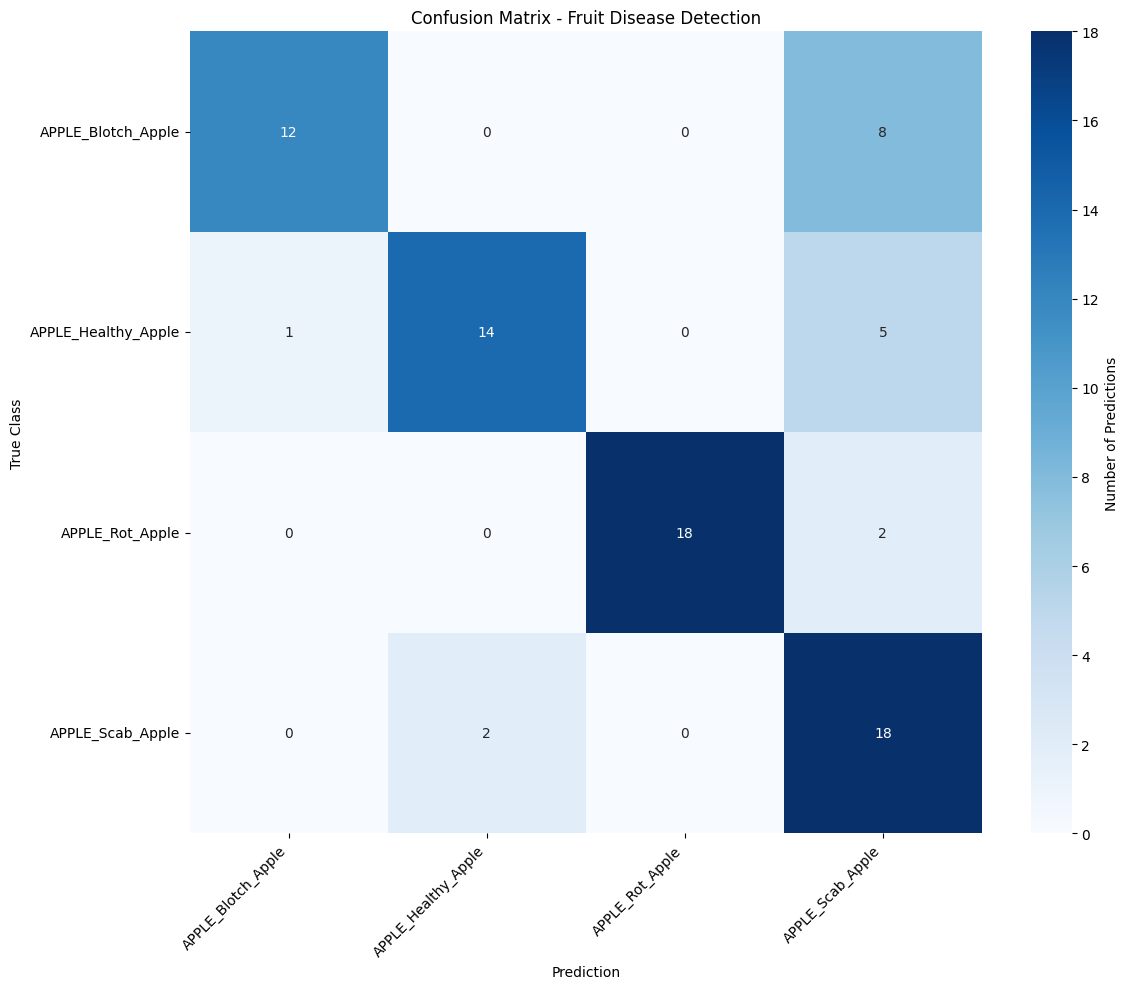


📈 CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
Class                Precision  Recall     F1-Score   Support   
--------------------------------------------------------------------------------
APPLE_Blotch_Apple   0.923      0.600      0.727      20        
APPLE_Healthy_Apple  0.875      0.700      0.778      20        
APPLE_Rot_Apple      1.000      0.900      0.947      20        
APPLE_Scab_Apple     0.545      0.900      0.679      20        
--------------------------------------------------------------------------------
Macro Avg            0.836      0.775      0.783      80        

💾 Confusion matrix saved at: yolo11_fruits/results/confusion_matrix.png
💾 Classification report saved at: yolo11_fruits/results/classification_report.json
🔍 STEP 13: ERROR ANALYSIS
🔄 Analyzing 80 predictions...
📊 ERROR SUMMARY:
   ✅ Correct predictions: 62
   ❌ Errors: 18
   🎯 Accuracy: 77.5%

🔍 MOST COMMON ERRORS:
   • APPLE_Blotch_Apple

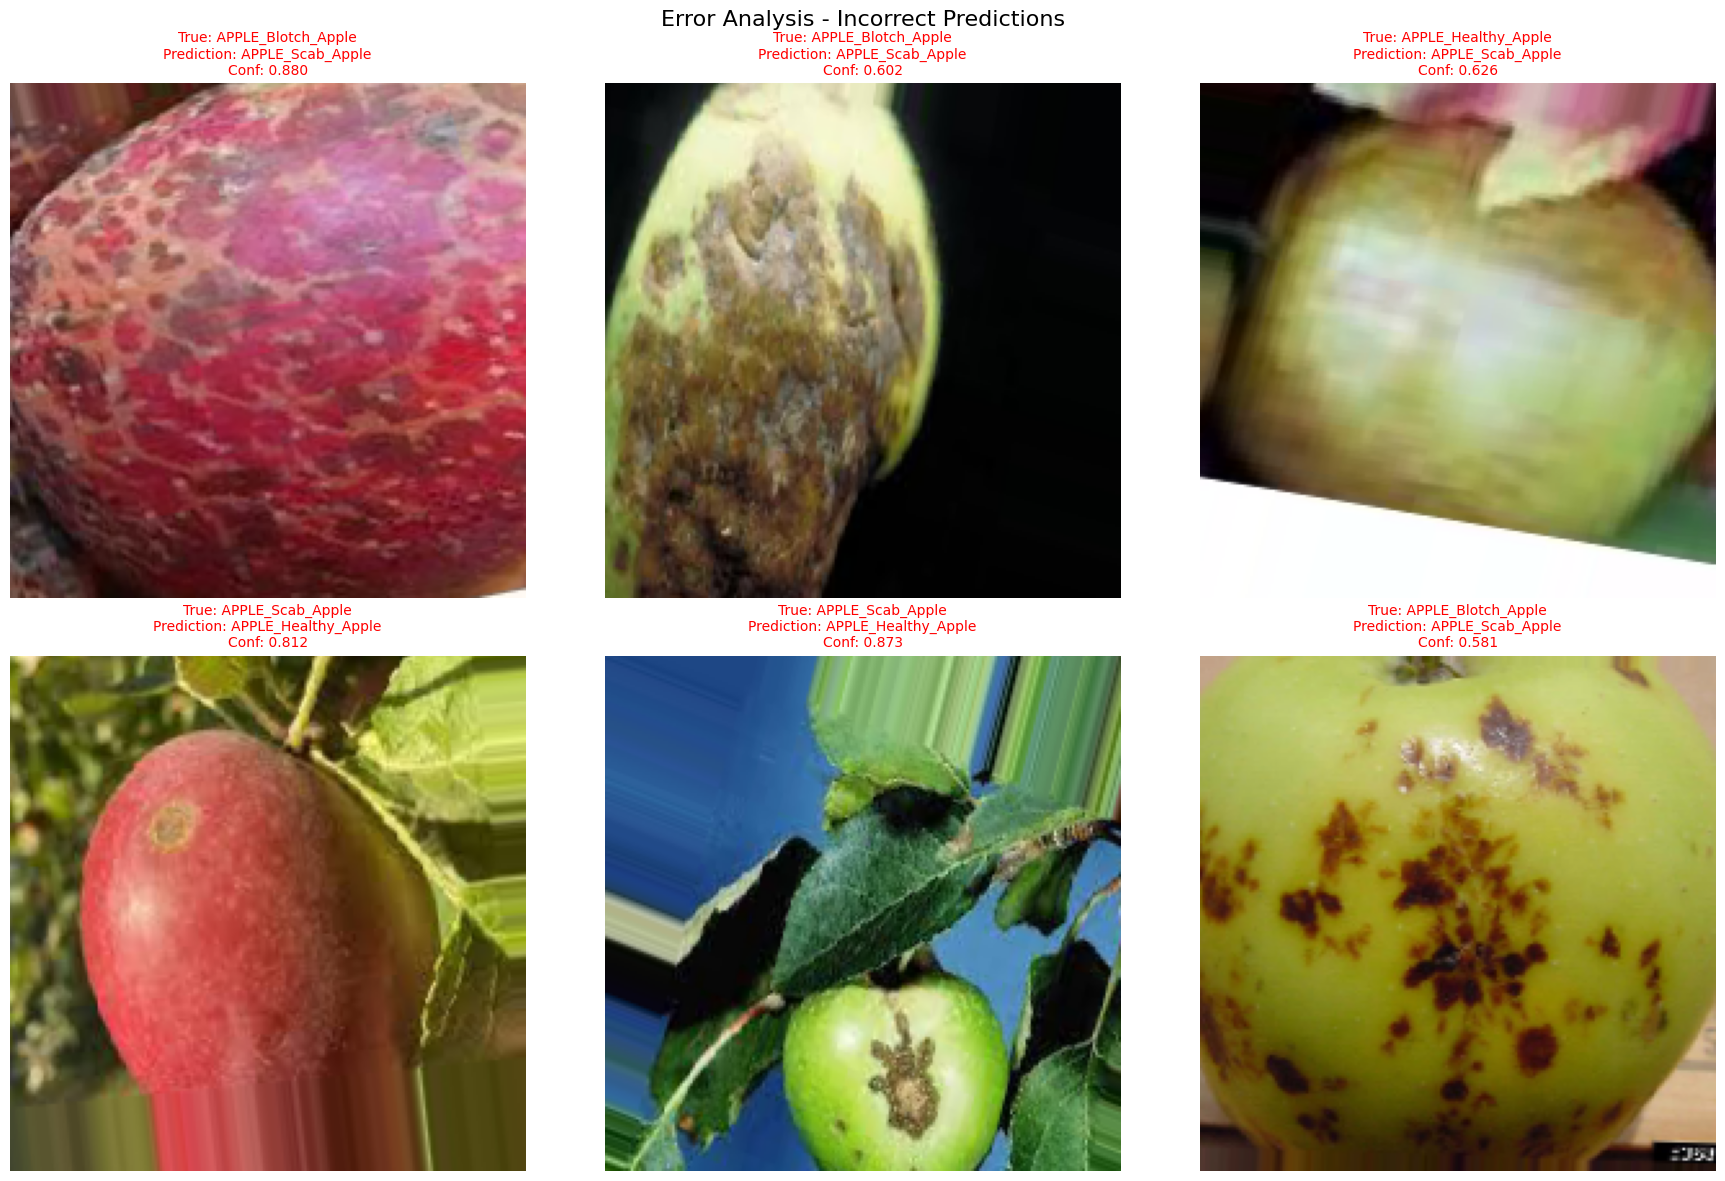

🎨 Error visualization saved at: yolo11_fruits/results/error_analysis_visualization.png

💾 Error analysis saved at: yolo11_fruits/results/error_analysis.json
📋 STEP 14: FINAL REPORT
🎉 PROJECT COMPLETED
📋 Final report generated:
   • Markdown: yolo11_fruits/results/final_report.md
   • JSON: yolo11_fruits/results/final_report.json

📊 Final model metrics:
   • mAP@0.5: 84.1%
   • Precision: 73.3%
   • Recall: 83.0%

📁 All files are located at: yolo11_fruits
🎯 The trained model is ready to use!

🎉 PIPELINE SUCCESSFULLY COMPLETED!


True

In [36]:
# Run the full pipeline
run_full_pipeline()

## 🏗️ Project Structure

After running the complete pipeline, your project structure will look like:

```
yolo11_fruits/
├── dataset/
│   ├── images/
│   │   ├── train/          # Training images
│   │   └── val/            # Validation images
│   └── labels/
│       ├── train/          # Training annotations
│       └── val/            # Validation annotations
├── fruit_detection/        # YOLO training outputs
│   ├── weights/
│   │   ├── best.pt         # Best model weights
│   │   └── last.pt         # Latest model weights
│   └── results.csv         # Training metrics
├── results/                # Analysis results
│   ├── class_distribution.png
│   ├── training_metrics.png
│   ├── predictions_visualization.png
│   ├── confusion_matrix.png
│   ├── error_analysis_visualization.png
│   ├── classification_report.json
│   ├── error_analysis.json
│   ├── inference_demo_results.csv
│   ├── reporte_final.md
│   └── reporte_final.json
└── fruit_config.yaml       # YOLO configuration
```

## 📊 Results and Metrics

The pipeline generates comprehensive metrics including:

- **mAP@0.5:** Mean Average Precision at IoU 0.5
- **mAP@0.5:0.95:** Mean Average Precision across multiple IoU thresholds
- **Precision/Recall:** Per-class and overall metrics
- **F1-Score:** Harmonic mean of precision and recall
- **Confusion Matrix:** Detailed classification performance
- **Error Analysis:** Common failure patterns and insights